# Preamble

**IMPORTANT:** Make sure to run the following cells in this section for everything else to work. 

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
import sys 
from os.path import abspath
from pathlib import Path
root_path = Path(abspath('..'))

if root_path not in sys.path: 
    sys.path.insert(0, root_path.as_posix())
print(sys.path[0])

/Users/Ismael/code/lensing/SMFF


In [3]:
import subprocess
import matplotlib.pyplot as plt
import os
from copy import deepcopy
import galsim 
import corner 
import numpy as np 

from matplotlib.patches import Ellipse

In [4]:
#directory to store data in. 
data_path = root_path.joinpath("data")
data_path.mkdir(exist_ok=True)

In [5]:
def showImage(image,ax=None,extent=None,vmin=None,vmax=None,origin='lower',cmap ='bwr'):
    
    if vmin == None: 
        vmin = -abs(image).max()
    if vmax == None: 
        vmax = abs(image).max()
    
    
    if ax is None: 
        return plt.imshow(image, cmap=cmap,vmax=vmax,vmin=vmin,interpolation='None',origin=origin, extent=extent)
    else: 
        return ax.imshow(image, cmap=cmap,vmax=vmax,vmin=vmin,interpolation='None',origin=origin,extent=extent)

In [6]:
def plot_matrix(matrix, param_names): 

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    n,_ = matrix.shape #assume square matrix
    plt.xticks(list(plt.xticks()[0]), [None] + param_names)
    plt.yticks(list(plt.yticks()[0]), [None] + param_names)
    
    plt.tick_params(labelsize=20)


    ax.matshow(matrix, cmap=plt.cm.Blues)


    for i in range(n):
        for j in range(n):
            c = matrix[j,i]
            ax.text(i, j, '{:.2g}'.format(c), va='center', ha='center',size=20)

In [7]:
latex_names =[r'$\rm{flux}$','$x_{0}$','$y_{0}$',r'$\rm{HLR}$','$\\varepsilon_{1}$','$\\varepsilon_{2}$']

In [8]:
#plotting constants
LINEWIDTH = 2
AXIS_NUMBER_SIZE = 45 
AXIS_LABEL_SIZE = 55 
AXIS_WIDTH = 3
AXIS_LENGTH = 12

FIG_SIZE = 40 

MARKER_SIZE = 14
LINE_WIDTH = 5

In [9]:
import corner 

from smff import defaults 
from smff.analysis import fisher
from smff.analysis import gparameters
from smff.analysis import models
from smff.analysis import images
from smff.analysis import readfits

In [10]:
#project folder name where you want to write galaxy information 
project1 = data_path.joinpath('project-paper1')
project2 = data_path.joinpath('project-paper2')
project3 = data_path.joinpath('project-paper3')

# Generate single galaxy files

In [80]:
#parameters of galaxy to draw. 
model = 'gaussian' #possible options of model and psf_model are in documentation. 
psf_model = 'gaussianpsf'
g1 = 0.2
g2 = 0.2
hlr = 1.0 # arcsecs.
psf_fwhm = .7
snr = 20. 

#image parameters 
pixel_scale=.2 #arcsecs/pixel
nx = 40
ny = 40 

In [81]:
cmd = (f'cd {root_path.as_posix()}; python -m smff.generate -p {project1.as_posix()} '
       f'-gal 1 --galaxy-model {model} --psf_model {psf_model}  --g1 {g1} --g2 {g2} --y0 0 --x0 0 '
       f'--flux 1. --psf_flux 1. --hlr {hlr} --psf_fwhm {psf_fwhm} --snr {snr}')
subprocess.run(cmd, shell=True);

In [82]:
cmd = (f'cd {root_path.as_posix()}; python -m smff.generate -p {project2.as_posix()} '
       f'-gal 1 --galaxy-model {model} --psf_model {psf_model}  --g1 {g1} --g2 0 --y0 0 --x0 0 '
       f'--flux 1. --psf_flux 1. --hlr {hlr} --psf_fwhm {psf_fwhm} --snr {snr}')
subprocess.run(cmd, shell=True);

In [83]:
cmd = (f'cd {root_path.as_posix()}; python -m smff.generate -p {project3.as_posix()} '
       f'-gal 1 --galaxy-model {model} --psf_model {psf_model}  --e1 0.1 --e2 0.1 --y0 0 --x0 0 '
       f'--flux 1. --psf_flux 1. --hlr {hlr} --psf_fwhm {psf_fwhm} --snr {snr}')
subprocess.run(cmd, shell=True);

# Load 

In [84]:
g_parameters = gparameters.GParameters(project1) #extract parameters from file created by generate.py 
image_renderer = images.ImageRenderer(pixel_scale=pixel_scale,
                                      nx=nx,ny=ny)
fish = fisher.Fisher(g_parameters=g_parameters,image_renderer=image_renderer, 
                     snr=snr)

In [85]:
#display the parameters that are stored. 
g_parameters.id_params['1']

OrderedDict([('galaxy_model', 'gaussian'),
             ('psf_model', 'gaussianpsf'),
             ('y0', 0.0),
             ('g2', 0.2),
             ('g1', 0.2),
             ('flux', 1.0),
             ('hlr', 1.0),
             ('x0', 0.0),
             ('psf_flux', 1.0),
             ('psf_fwhm', 0.7)])

# Display Fisher Formalism analysis 

## Draw galaxy generated 

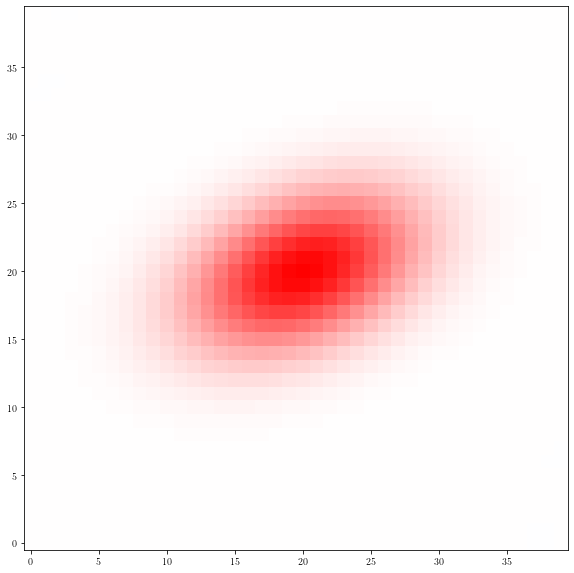

In [86]:
#get galaxy image and display it from fisher object. green is positive and red is negative 
fig = plt.figure(figsize=(10,10))
showImage(fish.image.array)
plt.show()


## Display derivatives 

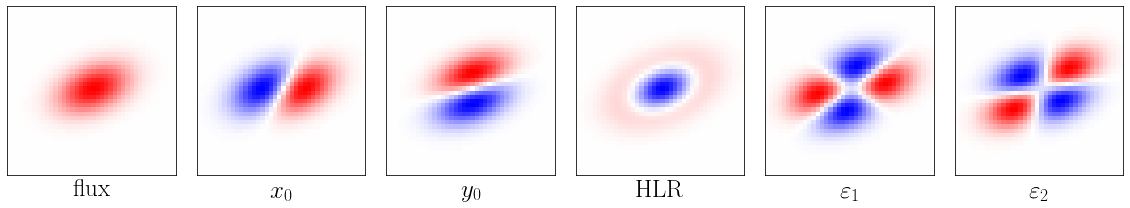

In [87]:
#draw partials images.
nrow,ncol = 1,6
fig = plt.figure(figsize=(20,20))
plt.rc('text', usetex=True)
for i,name in enumerate(fish.param_names):
    image = fish.derivatives_images[name]
    plt.subplot(nrow,ncol,i+1)
    showImage(image)
    #plt.title('Partial derivative with respect to {0}'.format(name[:-2]),fontsize=14)
    #plt.colorbar()
    plt.tick_params(
    axis='both',     
    which='both',      
    bottom=False,   
    top=False,        
    left=False,
    labelleft=False,
    right=False,
    labelbottom=False)
    plt.xlabel(latex_names[i],size=25)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.125, hspace=.1)

## Display fisher matrix 


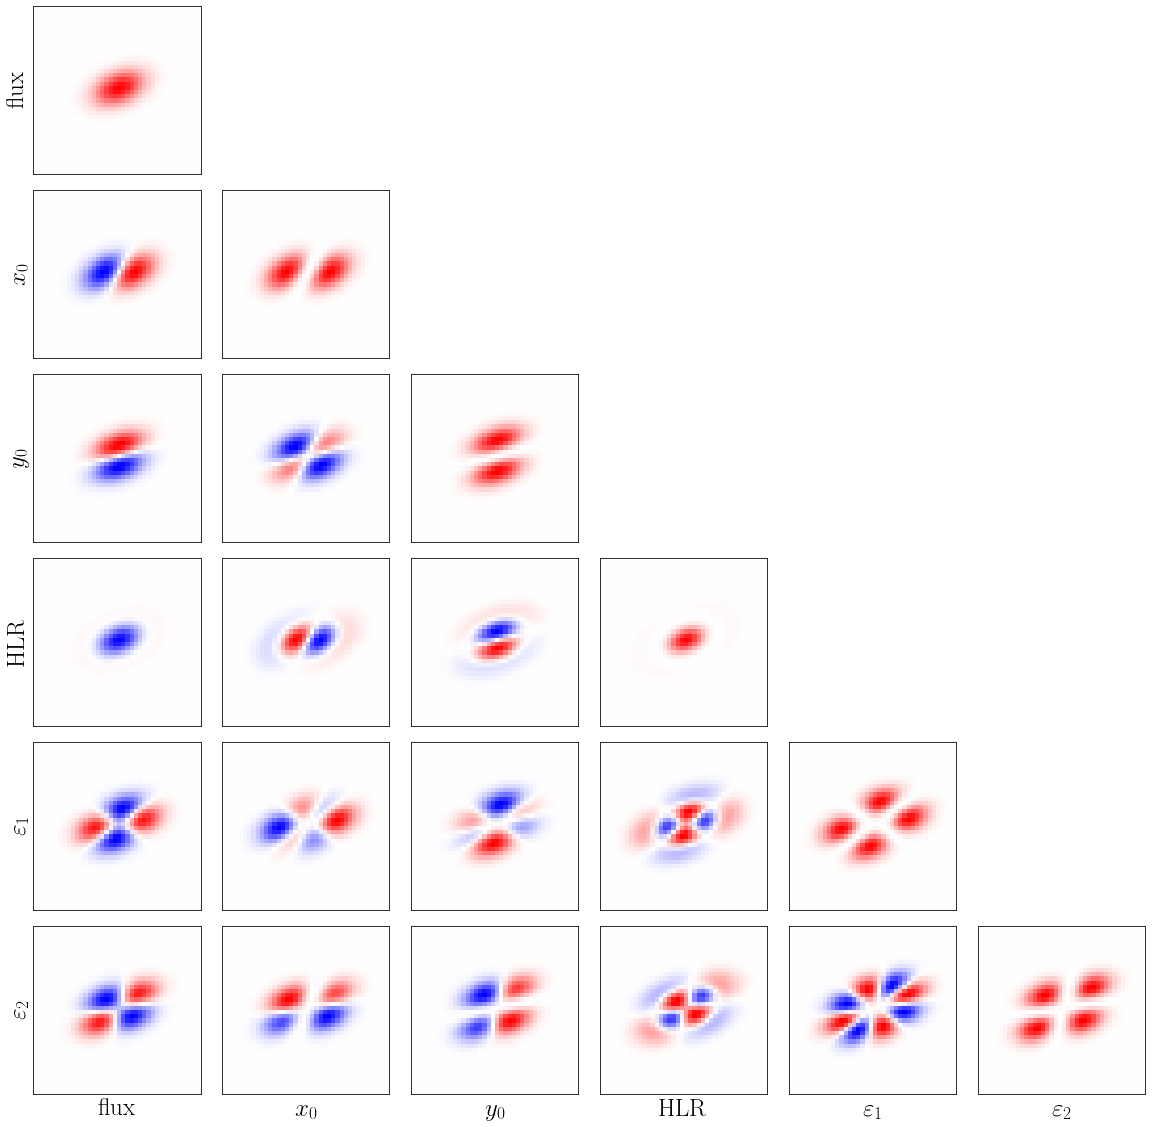

In [88]:
figure = plt.figure(figsize=(20,20))
# figure.suptitle('Fisher matrix elements',
#                 fontsize=20)
for i in range(fish.num_params):
    for j in range(fish.num_params):
        if i >= j:
            ax = figure.add_subplot(fish.num_params,
                                    fish.num_params,
                                    fish.num_params * i + j + 1)
            showImage(fish.fisher_matrix_images[
                          fish.param_names[i],
                          fish.param_names[j]
                      ],ax)
            
                 
            if j == 0: 
                plt.tick_params(
                axis='both',     
                which='both',      
                bottom=False,   
                top=False,        
                left=False,
                labelleft=False,
                right=False,
                labelbottom=False)
                plt.ylabel(latex_names[i],size=25)
            if i == fish.num_params-1: 
                plt.tick_params(
                axis='both',     
                which='both',      
                bottom=False,   
                top=False,        
                left=False,
                labelleft=False,
                right=False,
                labelbottom=False)
                plt.xlabel(latex_names[j],size=25)
            if i!= 0 and j!= fish.num_params-1: 
                plt.tick_params(
                axis='both',     
                which='both',      
                bottom=False,   
                top=False,        
                left=False,
                labelleft=False,
                right=False,
                labelbottom=False)
            plt.rc('text', usetex=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=.1)


## Display bias 

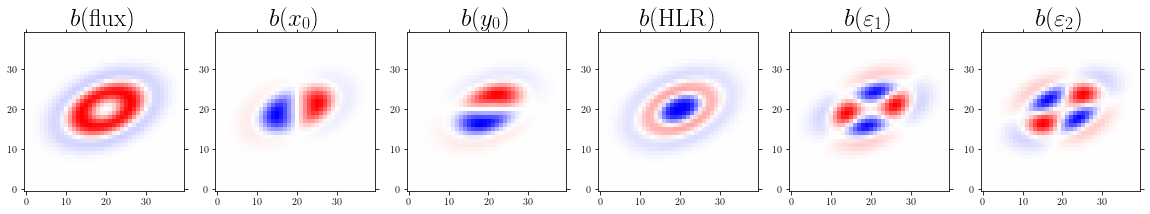

In [89]:
#draw bias images.
nrow,ncol = 1, 6
fig = plt.figure(figsize=(20,20))
for i,name in enumerate(fish.param_names):
    image = fish.bias_images[name]
    plt.subplot(nrow,ncol,i+1)
    showImage(image)
    plt.title('$b(${0}$)$'.format(latex_names[i]),fontsize=25)
    #plt.colorbar()
    plt.tick_params(
    axis='both',     
    which='both',      
    bottom='off',   
    top='off',        
    left='off',
    labelleft='off',
    right='off',
    labelbottom='off')
    plt.rc('text', usetex=True)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=.1)


# More Bias Images

In [90]:
# Here we are using project2 which contains a galaxy with g2=0, instead of g1=g2 as in the previous example. 

g_parameters = gparameters.GParameters(project2) #extract parameters from file created by generate.py 
image_renderer = images.ImageRenderer(pixel_scale=pixel_scale,
                                      nx=nx,ny=ny)
fish = fisher.Fisher(g_parameters=g_parameters,image_renderer=image_renderer, 
                     snr=snr)

In [91]:
param_names = ['flux_1', 'x0_1',  'g1_1', 'hlr_1',  'y0_1',  'g2_1']
clatex_names= [r'$\rm{flux}$', '$x_{0}$', '$\\varepsilon_{1}$',r'$\rm{HLR}$','$y_{0}$','$\\varepsilon_{2}$']

## Nicer bias image 

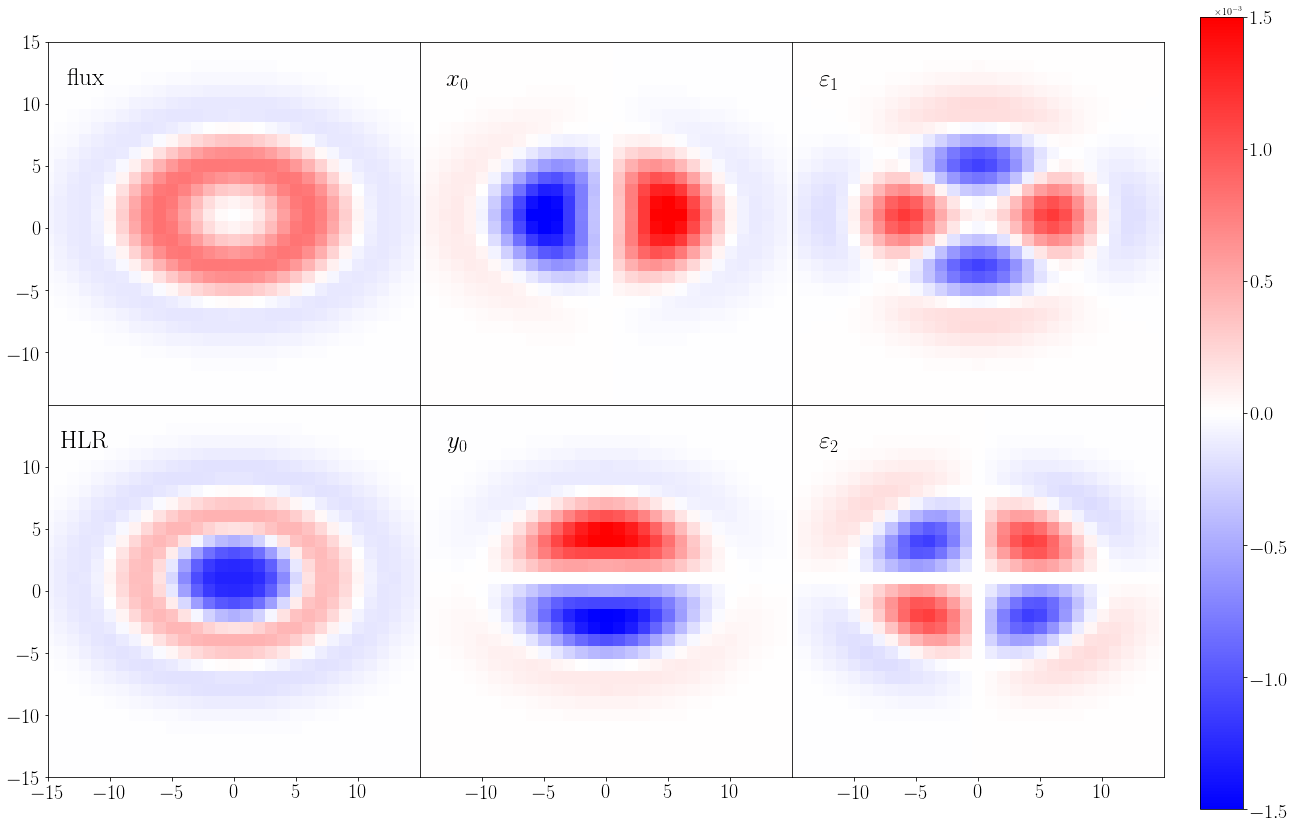

In [92]:
#draw bias images.
plt.rc('text', usetex=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable

nrow,ncol = 2,3
fig = plt.figure(figsize=(20,20))
for i,name in enumerate(param_names):
    image = fish.bias_images[name] /np.sqrt(fish.covariance_matrix[name,name])
    ax = plt.subplot(nrow,ncol,i+1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim((-15,15))
    plt.ylim((-15,15))

    if i==3: 
        plt.xticks([-15, -10, -5, 0, 5, 10], ['$-15$', '$-10$', '$-5$', '$0$', '$5$', '$10$'])
        
    else: 
        plt.xticks([-10, -5, 0, 5, 10], ['$-10$', '$-5$', '$0$', '$5$', '$10$'])
    
    if i==0: 
        plt.yticks([-10, -5, 0, 5, 10, 15], ['$-10$', '$-5$', '$0$', '$5$', '$10$', '$15$'])
    else: 
        plt.yticks([-15, -10, -5, 0, 5, 10], ['$-15$', '$-10$', '$-5$', '$0$', '$5$', '$10$'])
    

    
    if i == 0: 
        plt.tick_params(
        axis='both',     
        which='both',      
        bottom=False,   
        top=False,        
        left=True,
        labelleft=True,
        right=False,
        labelbottom=False)
    
    if i in [1,2]: 
        plt.tick_params(
        axis='both',     
        which='both',      
        bottom=False,   
        top=False,        
        left=False,
        labelleft=False,
        right=False,
        labelbottom=False)    
        
        
    if i in [4,5]: 
        plt.tick_params(
        axis='both',     
        which='both',      
        bottom=True,   
        top=False,        
        left=False,
        labelleft=False,
        right=False,
        labelbottom=True)  

    im = showImage(image,vmin=-.0015,vmax=.0015,extent=[-20.5,19.5,-19.5,20.5])
    plt.text(.1,.9,'${0}$'.format(clatex_names[i]),fontsize=25,ha='center', va='center', transform=ax.transAxes,fontweight='bold')
    
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    

#cbar = plt.colorbar(fraction=0.1, pad=0.14)
cbar_ax = fig.add_axes([0.925, 0.225, 0.03, 0.55])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20) 
#     cbar.ax.text(-0.25, 1, r'$\times$10$^{-3}$', va='top', ha='left')
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
#cbar.ax.get_yaxis().labelpad = 35
#cbar.ax.set_ylabel(r'$b \, \frac{20.0}{SNR}$', rotation=270,size=40)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=-.5)


## Compare biases on chi and epsilon

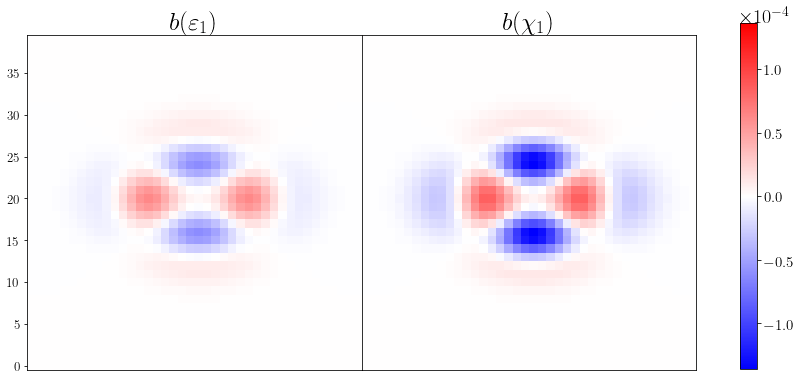

In [24]:
#\eps = .2 for both components. 
fig, axes = plt.subplots(1,2,sharey='all',  figsize = (12,12))
plt.rc('text', usetex=True)

#get corresponding chi/ e 
shr = galsim.shear.Shear(g1 = g1, g2 = 0 )
e1, e2 = shr.e1, shr.e2

#obtain the other fish. 
new_id_params = deepcopy(fish.g_parameters.id_params)
new_id_params['1'].pop('g1'); new_id_params['1'].pop('g2') #make sure my program doesn't get confused. 
new_id_params['1']['e1'] = e1; new_id_params['1']['e2'] = e2
new_g_parameters = gparameters.GParameters(id_params=new_id_params)
new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = snr)

#get max value and min value to have same scale. 
min_value = min(fish.bias_images['g1_1'].min(), new_fish.bias_images['e1_1'].min()) 
max_value = max(fish.bias_images['g1_1'].max(), new_fish.bias_images['e1_1'].max(), np.absolute(fish.bias_images['g1_1'].min()), 
                                                                                               np.absolute(new_fish.bias_images['e1_1'].min())) 


#draw first image with eps 
showImage(fish.bias_images['g1_1'], ax = axes[0], vmin = -max_value, vmax = max_value )
axes[0].set_title('$b(\\varepsilon_{1})$', size = 25)

axes[0].yaxis.set_tick_params(labelsize=13)

axes[0].tick_params(
axis='both',     
which='both',      
bottom=False,   
top=False,        
left=True,
labelleft=True,
right=False,
labelbottom=False)


#draw second image to compare  
im = showImage(new_fish.bias_images['e1_1'], ax = axes[1], vmin = -max_value, vmax = max_value)
axes[1].set_title('$b(\\chi_{1})$', size = 25)

axes[1].tick_params(
axis='both',     
which='both',      
bottom=False,   
top=False,        
left=False,
labelleft=False,
right=False,
labelbottom=False)

#add colorbar to this first two. 
cbaxes = fig.add_axes([0.95, 0.31, 0.02, .4]) 
cbar = fig.colorbar(im, ax = axes.ravel().tolist(), cax = cbaxes)
cbar.ax.tick_params(labelsize=15) 
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.ax.yaxis.set_offset_position('left')
cbar.ax.yaxis.get_offset_text().set(size=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=-.5)

plt.show() 

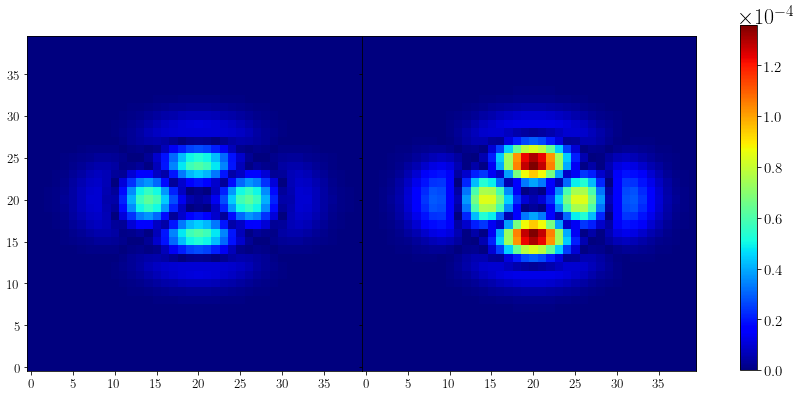

In [25]:
#maybe more like a rainbow for the second? 
#plt.figure(figsize =(10,10))
#draw the first and second image again but with magnitude. 
plt.rc('text', usetex=True)
fig, axes = plt.subplots(1,2,sharey='all', figsize = (12,12))

max_value = max(np.absolute(fish.bias_images['g1_1']).max(), np.absolute(new_fish.bias_images['e1_1']).max()) 

im = showImage(np.absolute(fish.bias_images['g1_1']), ax = axes[0], cmap = 'jet', vmin = 0, vmax =max_value )
axes[0].yaxis.set_tick_params(labelsize=13)
axes[0].xaxis.set_tick_params(labelsize=13)



im = showImage(np.absolute(new_fish.bias_images['e1_1']),  ax = axes[1], cmap= 'jet', vmin = 0, vmax = max_value )
axes[1].xaxis.set_tick_params(labelsize=13)


cbaxes = fig.add_axes([0.95, 0.31, 0.02, .4]) 
cbar = fig.colorbar(im, ax = axes.ravel().tolist(), cax = cbaxes)
cbar.ax.tick_params(labelsize=15) 
#     cbar.ax.text(-0.25, 1, r'$\times$10$^{-3}$', va='top', ha='left')
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.ax.yaxis.set_offset_position('left')
cbar.ax.yaxis.get_offset_text().set(size=22)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0)

plt.show()

#now the differences between the horizontal and vertical lobes is more clearly shown. 

# Bias as a function of size and ellipticity

## Bias as a function of size 

In [97]:
# load project 1 again. 
g_parameters = gparameters.GParameters(project1) #extract parameters from file created by generate.py 
image_renderer = images.ImageRenderer(pixel_scale=pixel_scale,
                                      nx=nx,ny=ny)
fish = fisher.Fisher(g_parameters=g_parameters,image_renderer=image_renderer, 
                     snr=snr)

In [108]:
# snr_norm = 20 #nominal snr to use. 
def bias_Size(fish,image_renderer,params, num_params):
    """Plot of bias*(snr_norm/snr)**2 as a function of hlr/psf_fwhm with a fixed snr."""
    
    plt.rc('text', usetex=True)

    steps = 25
    x_range = (.8, 3.0)  # x = hlr_gal / hlr_psf
    xs = np.linspace(x_range[0], x_range[1], steps)
    figure = plt.figure(figsize=(FIG_SIZE, FIG_SIZE))
    id_params = deepcopy(fish.g_parameters.id_params)
    snr_norm = fish.snr #normally use 20.

    ys = {} # y= bias*snr^2
    for x in xs:
        gal_id = next(iter(id_params)) #obtain first key in id_params (there is only one)
        hlr_psf = id_params[gal_id]['psf_fwhm'] / 2.
        hlr = x * hlr_psf
        id_params[gal_id]['hlr'] = hlr
        g_parameters = gparameters.GParameters(id_params=id_params)
        new_fish = fisher.Fisher(g_parameters,image_renderer, snr)
        biases = new_fish.biases
        for i,param in enumerate(params):
            if param not in ys:
                ys[param] = []
            bias = biases[param]
            y = bias
            if 'hlr' in param:
                y /= hlr_psf
            ys[param].append(y)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.28, hspace=None)



    #do not plot x0 and y0
    extra = r'$\, \left(' + str(int(snr_norm)) + r'/\rm{SNR}\right)^{2}$'
    y_names = [r'$b(\rm{flux})$',
                r'$b(\rm{HLR})/\rm{HLR_{PSF}}$', '$b(\\varepsilon_{1})$',
                '$b(\\varepsilon_{2})$']
    units = [r'$10^{-3}$',r'$10^{-3}$', '$10^{-3}$', '$10^{-3}$']
    y_titles = [elt + extra + '  [{0}]'.format(unit) for elt,unit in zip(y_names,units)]
    x_titles = [r'\rm{HLR/HLR}$_{\rm{PSF}}$'] * 6
    ranges_x = [None,[0.4,3.0],[0.4,3.0],[0.4,3.0]]
    ranges_y = [[-1e-3,6e-3],None,None,None]
    for i,param in enumerate(params):
        ax = figure.add_subplot(2, num_params / 2,
                                i + 1)
        
        ax.plot(xs, ys[param],'-o',linewidth=LINE_WIDTH,markersize=MARKER_SIZE)
        
        ax.set_xticks(np.linspace(0,3.2,5)) 

        ax.set_xlabel(x_titles[i], fontsize=AXIS_LABEL_SIZE)
        ax.set_ylabel(y_titles[i], fontsize=AXIS_LABEL_SIZE)
        ax.tick_params(labelsize=AXIS_NUMBER_SIZE)
        

        
        ax.tick_params(which='both', width=AXIS_WIDTH,length=AXIS_LENGTH)
                
        plt.axhline(0,color='r')
        if ranges_x[i] != None: 
            plt.xlim(ranges_x[i])
        if ranges_y[i] != None: 
            plt.ylim(ranges_y[i])
            
        #multiply axis by 10**3 (but leave everything the same)
        new_y_labels = [] 
        for y in ax.get_yticks(): 
            new_y_labels.append(r'${:.2g}$'.format(y*10**3))
        ax.set_yticklabels(new_y_labels)




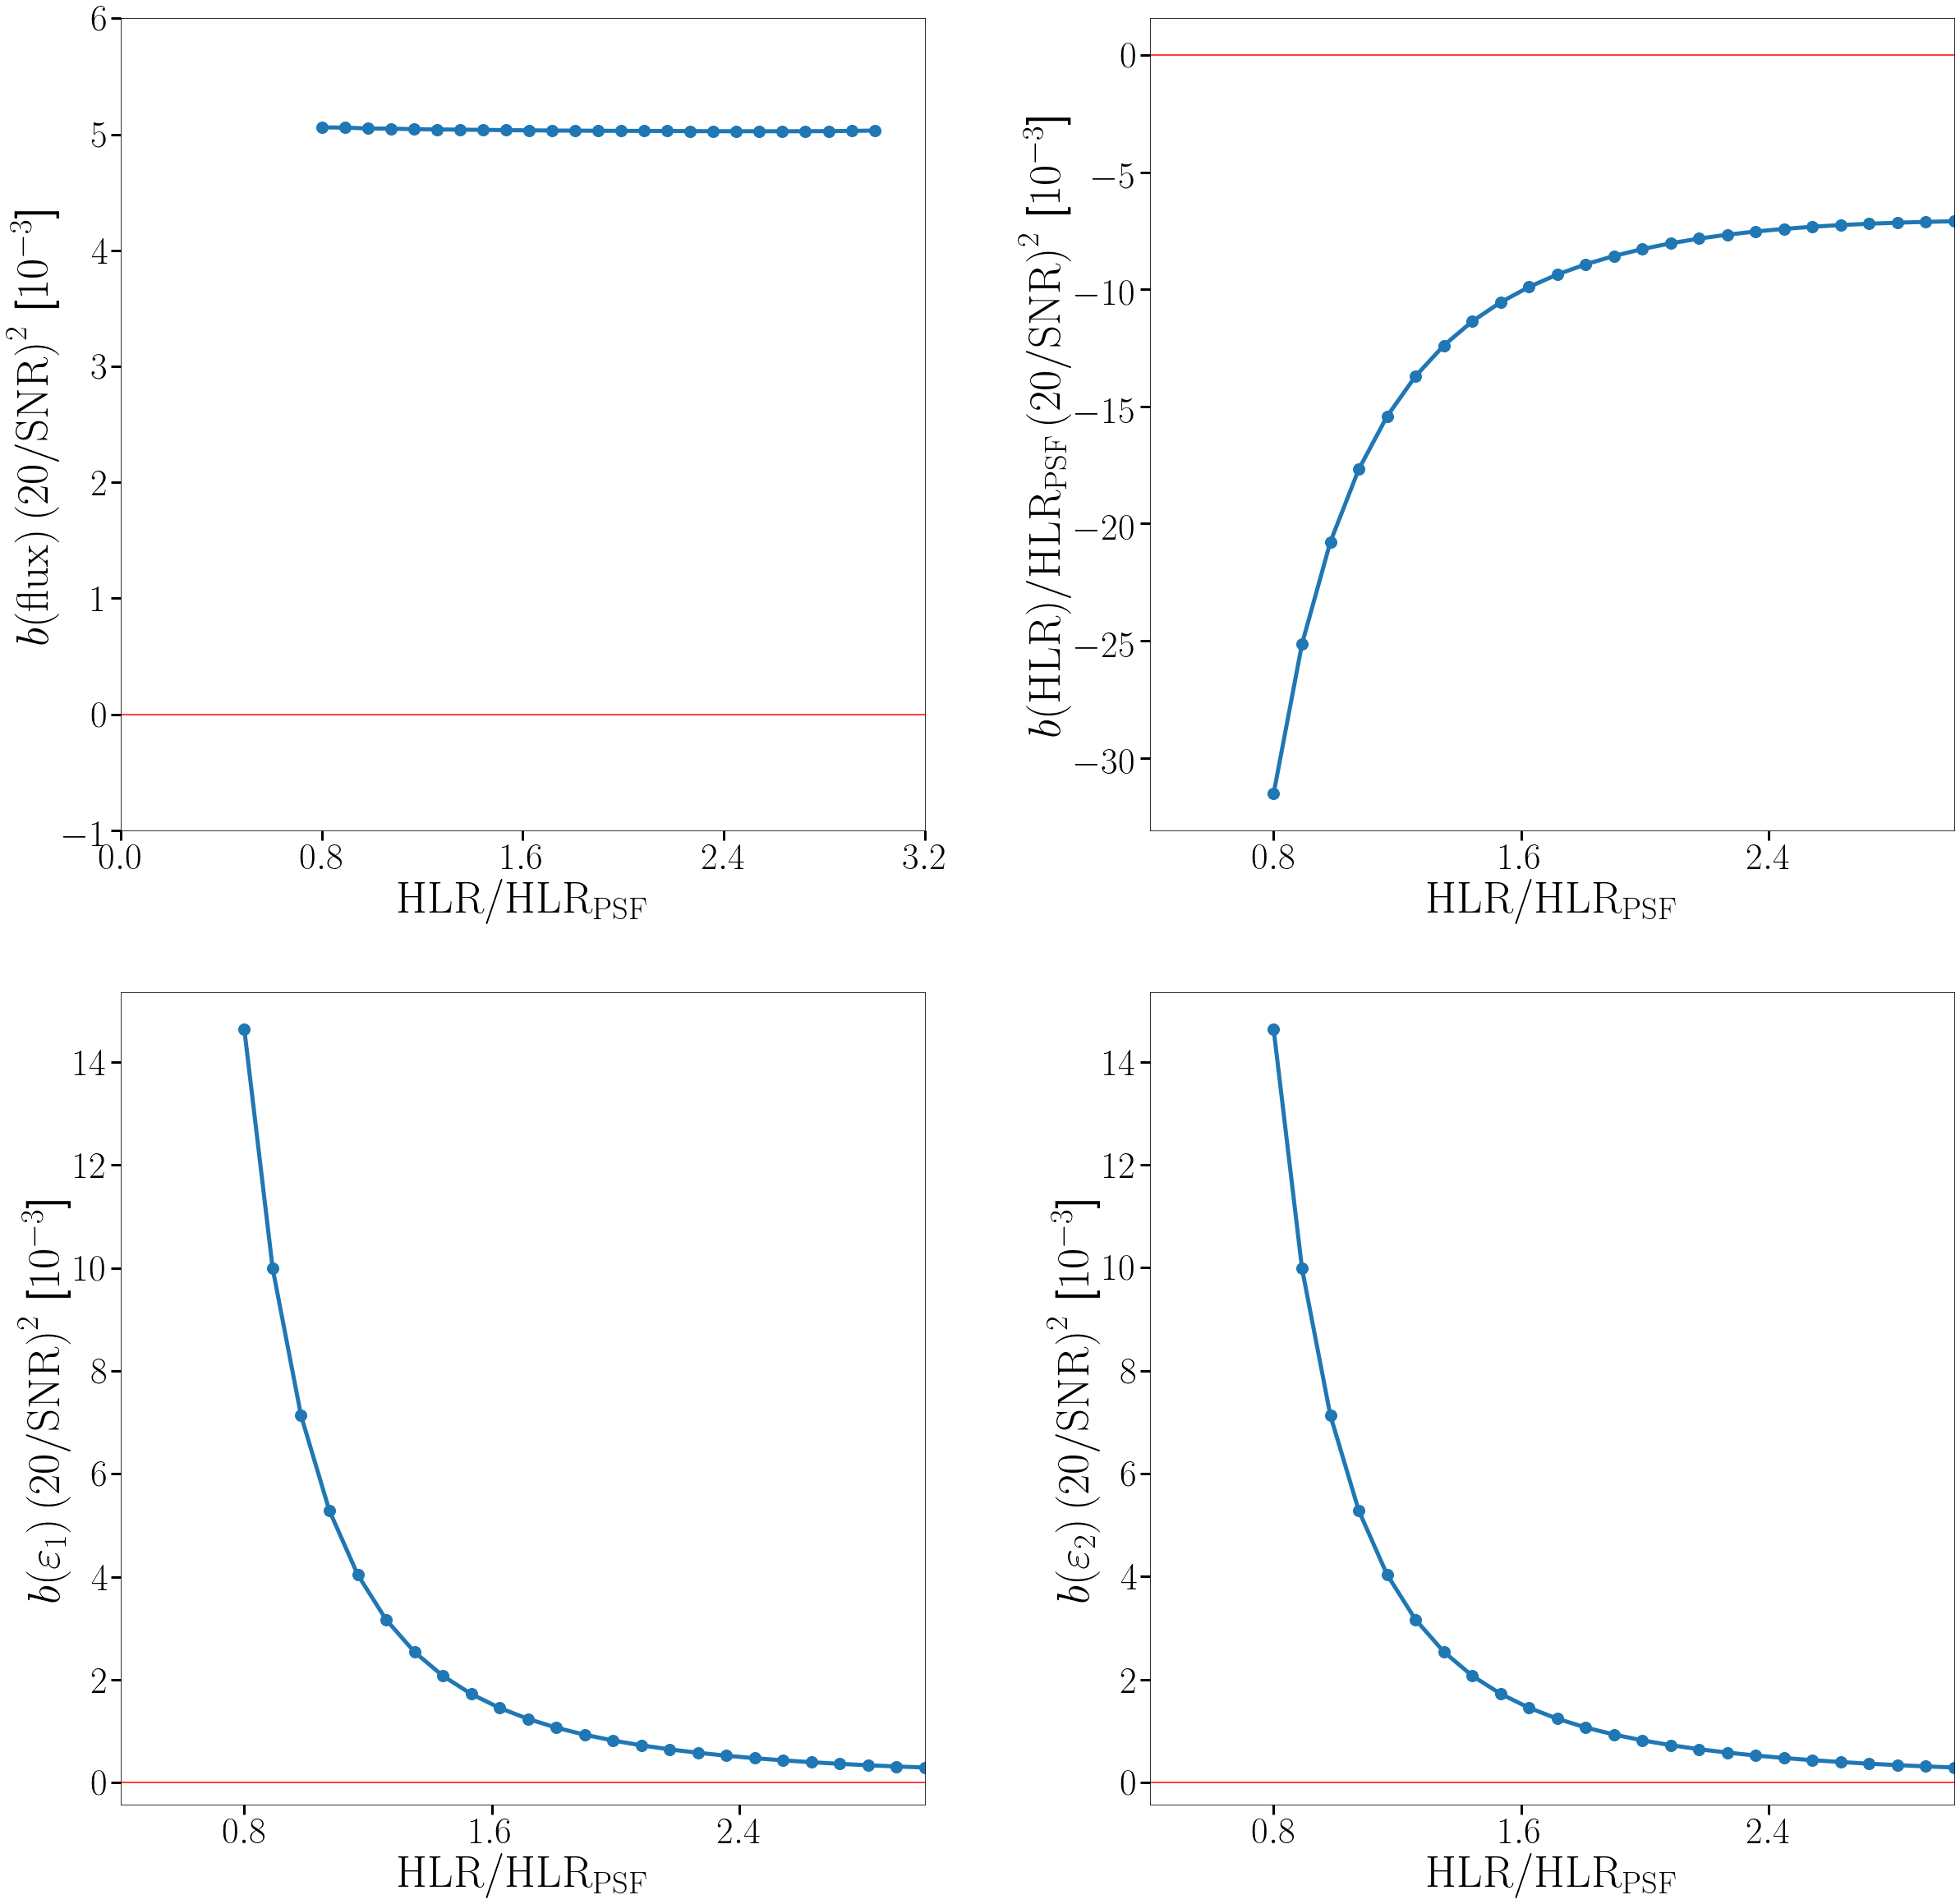

In [109]:
params = [fish.param_names[0]] + fish.param_names[3:] #want flux and not x0,y0
fig = bias_Size(fish,image_renderer,params, fish.num_params-2)

## Bias as a function of ellpticity 

In [110]:
#bias on parameters as a function of a component of ellipticity.
snr_norm = 20
def bias_ellipticity(fish,image_renderer,params, num_params):
    """Plot of bias*(snr_norm/snr)**2 as a function of e1 (all other parameters fixed.)"""

    plt.rc('text', usetex=True)
    steps = 30
    x_range = (-.6, .6)  #x = g1 
    xs = np.linspace(x_range[0], x_range[1], steps)
    figure = plt.figure(figsize=(FIG_SIZE, FIG_SIZE))
    id_params = deepcopy(fish.g_parameters.id_params)
    ys = {} # y= bias*snr2
    for x in xs:
        gal_id = next(iter(id_params))
        hlr_psf = id_params[gal_id]['psf_fwhm'] / 2.
        id_params[gal_id]['g1'] = x
        g_parameters = gparameters.GParameters(id_params=id_params)
        fish = fisher.Fisher(g_parameters,image_renderer, snr)
        biases = fish.biases
        for i,param in enumerate(params):
            if param not in ys:
                ys[param] = []
            bias = biases[param]
            if 'hlr' in param:
                bias = bias / hlr_psf
            ys[param].append(bias)


    #do not plot x0 and y0
    units = ['$10^{-3}$',r'$10^{-3}$', '$10^{-3}$', '$10^{-3}$']
    extra = r'$\, \left(' + str(snr_norm) + r'/\rm{SNR}\right)^{2}$'
    y_names = [r'$b(\rm{flux})$',
                r'$b(\rm{HLR})/\rm{HLR_{PSF}}$', '$b(\\varepsilon_{1})$',
                '$b(\\varepsilon_{2})$']
    y_titles = [elt + extra + "  [{0}]".format(unit) for (elt,unit) in zip(y_names,units)]
    x_titles = ['$\\varepsilon_{1}$'] * 4
    for i,param in enumerate(params):
        ax = figure.add_subplot(2, num_params / 2,
                                i + 1)
        ax.plot(xs, ys[param],'-o', markersize=MARKER_SIZE,linewidth=LINE_WIDTH)
        ax.set_xlabel(x_titles[i], fontsize=AXIS_LABEL_SIZE)
        ax.set_ylabel(y_titles[i], fontsize=AXIS_LABEL_SIZE)
        ax.tick_params(labelsize=AXIS_NUMBER_SIZE)
        ax.tick_params(which='both', width=AXIS_WIDTH,length = AXIS_LENGTH)
        
        plt.axhline(0,color='r')
        
        new_y_labels = [] 
        for y in ax.get_yticks(): 
            new_y_labels.append(r'${:.2g}$'.format(y*10**3))
        ax.set_yticklabels(new_y_labels)




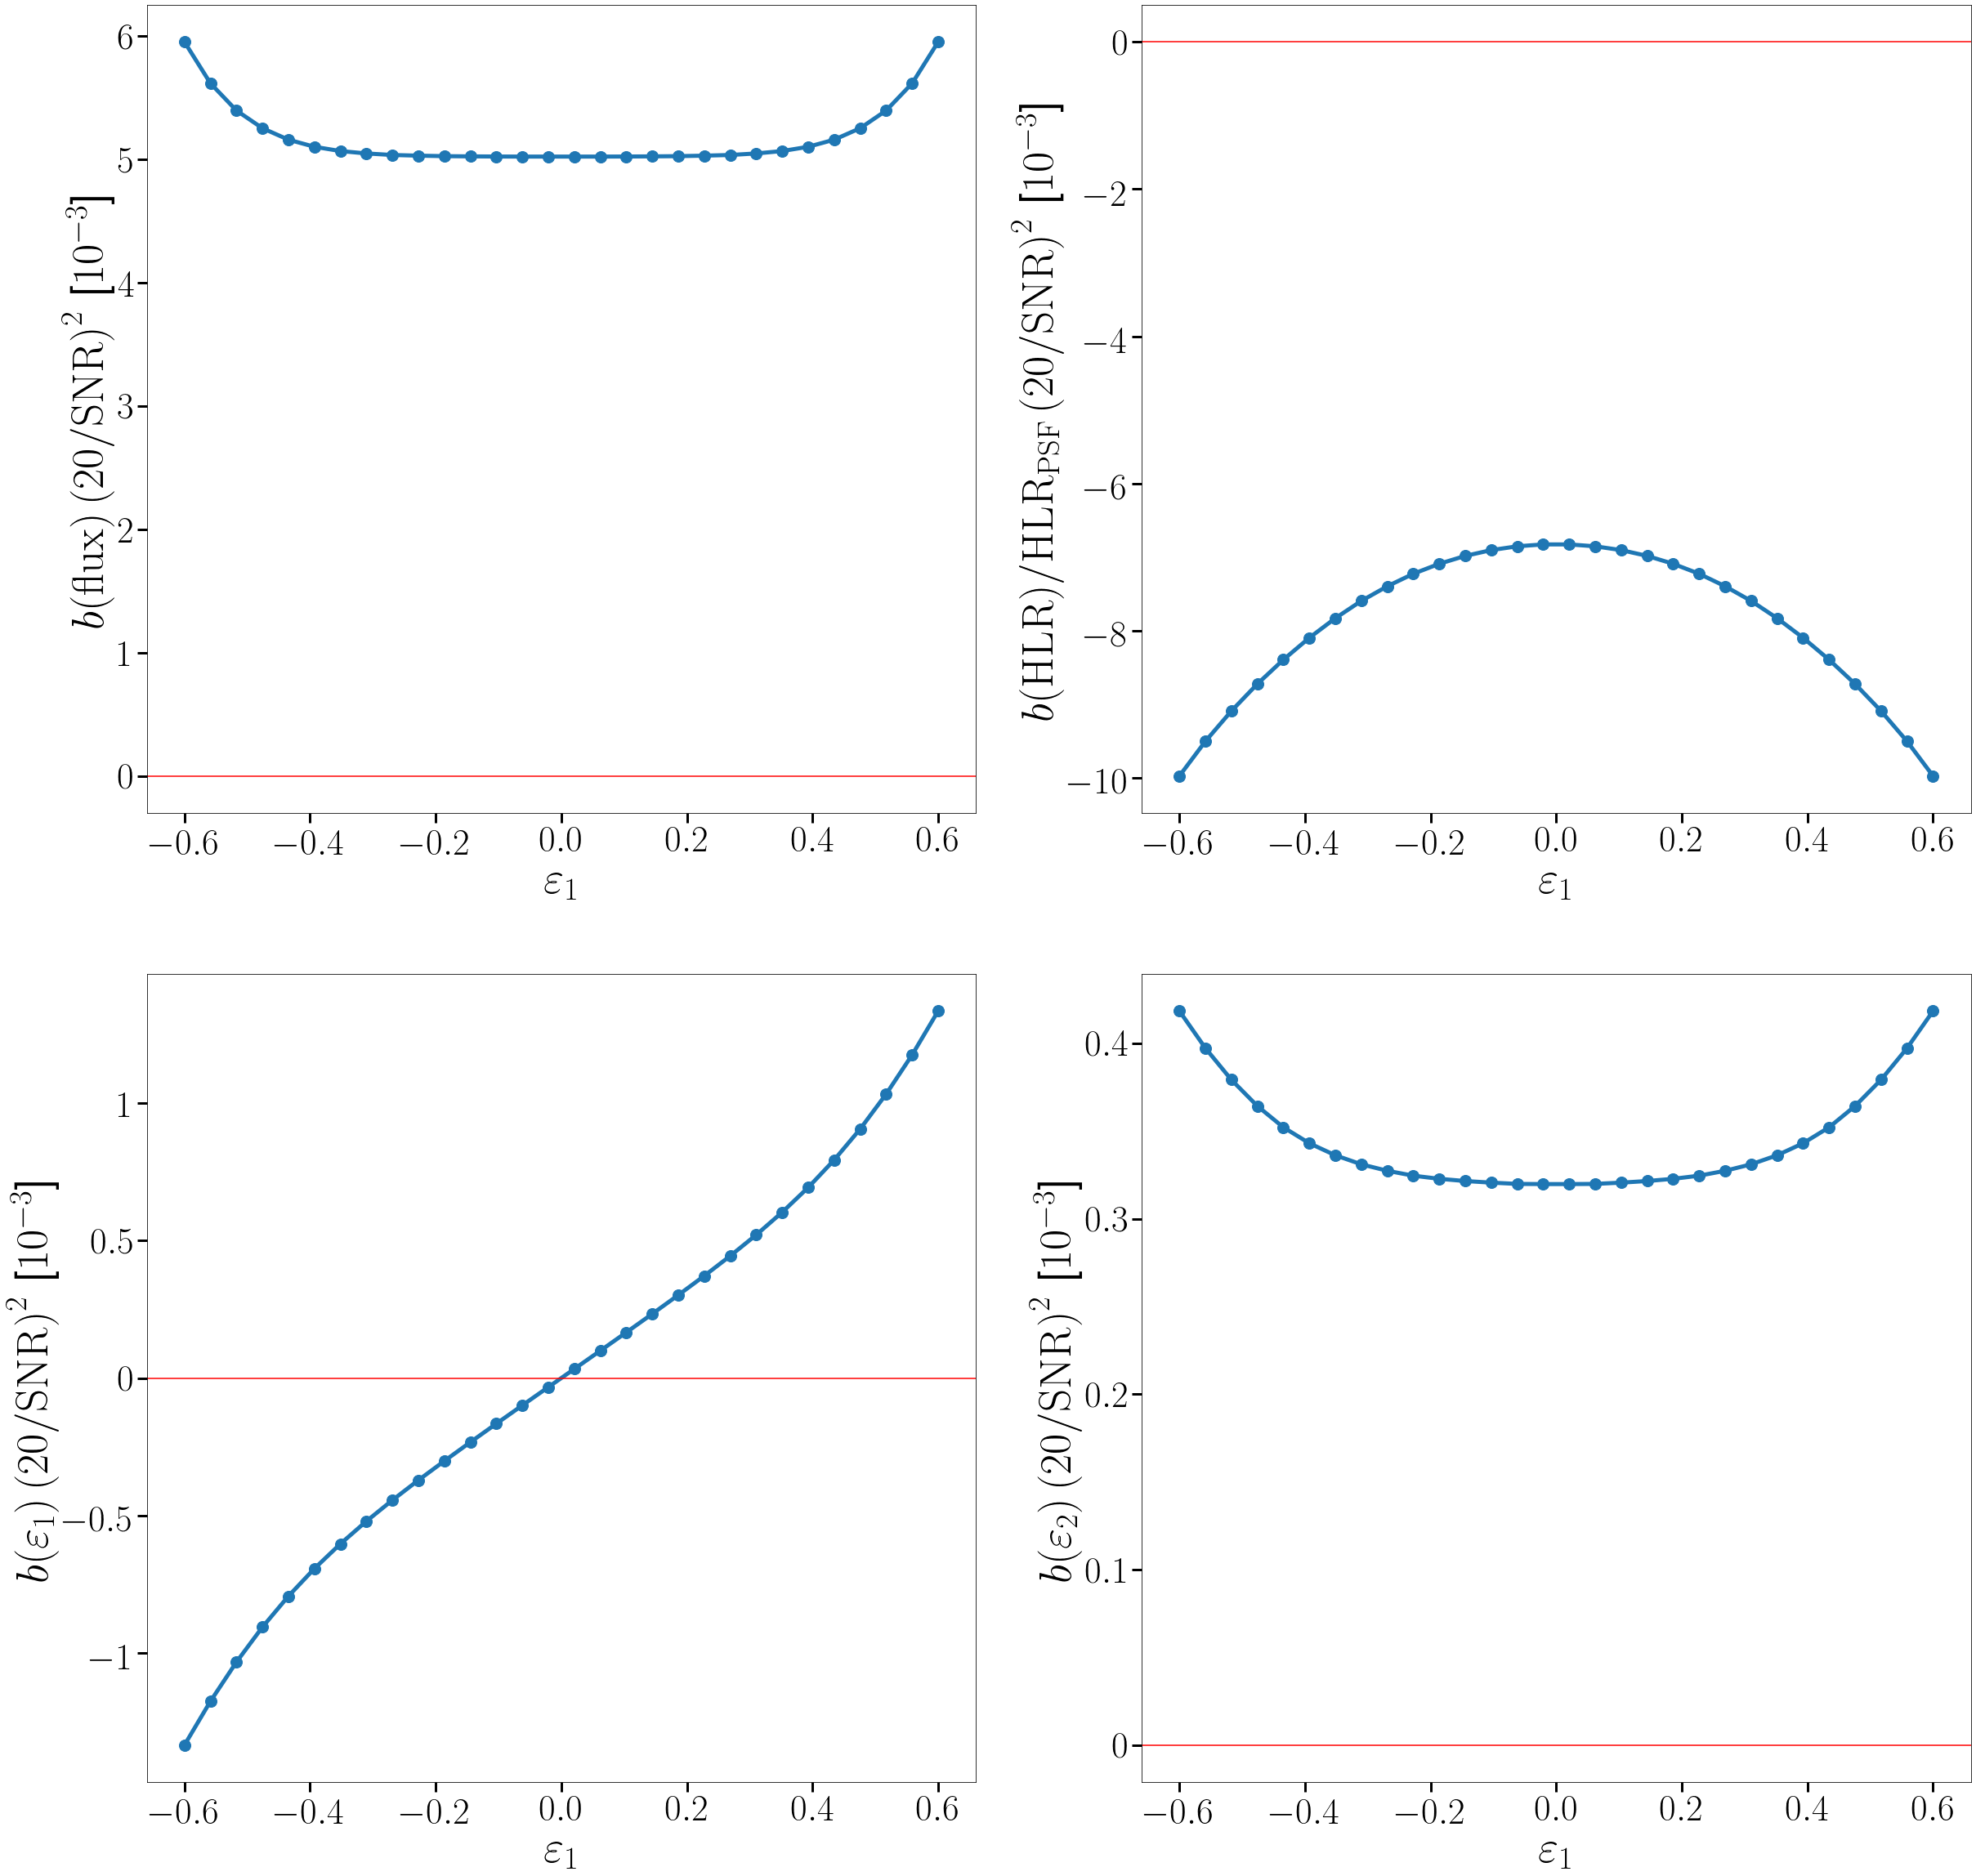

In [111]:
params = [fish.param_names[0]] + fish.param_names[3:] #want flux and not x0,y0
bias_ellipticity(fish,image_renderer,params, fish.num_params-2)

## Reproduce Hirata's results 

In [30]:
def get_R2(fish, psf_T, img_size): 
    return 1 - psf_T / (2 * fish.model.calculateMomentRadius(size = img_size, scale = .2 ,rtype= 'trace')**2 ) 

In [31]:
def prepare_hlrss1(starts, end, pts): 
    hlrss = []
    for start in starts: 
        hlrs = np.linspace(start, end, pts)
        hlrss.append(hlrs)
    return hlrss 

def prepare_hlrss_nlinear(starts, end, pts): 
    hlrss = []
    for start in starts: 
        ys = np.linspace(start**(-2), end**(-2), pts)
        hlrs = ys**(-0.5)
        hlrss.append(hlrs)
    return hlrss 


def get_params_to_vary(vary , g,  hlr): 
    if vary == 'both': 
        return [g, g, hlr]
    
    elif vary == 'g1': 
        return [g,0,hlr]
    
    elif vary == 'g2' :
        return [0, g, hlr]
    else: 
        raise ValueError

In [76]:
def get_legend_label(vary, eps1, eps2, precision): 
    eps1_string = "{:.{prec}f}".format(eps1, prec = precision)
    eps2_string = "{:.{prec}f}".format(eps2, prec = precision)
    if eps1 == eps2 and vary == 'both': 
        return f"$\\varepsilon_{1} = \\varepsilon_{2} = {eps1_string}$"
    else: 
        return f"$\\varepsilon_{1} = {eps1_string}, \\varepsilon_{2} = {eps2_string} $"

def get_formatting(xlabel, ylabel,  gs, vary = 'both', xlim = None , ylim = None, check_sci = False, 
                   dash_and_solid = False, hline = None, vline = None, legend_size = 30, lg_precision = 1):
    
    plt.rc('text',usetex=True)
    
    def formatting(ax): 
        ax.tick_params(axis='both', which='major', labelsize=25)

        ax.set_xlabel(xlabel, size = 30)
        ax.set_ylabel(ylabel, size = 30)
        
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        ax.yaxis.set_ticks_position('both')
        
        if 'specific' in check_sci:
            pwr = float(check_sci[len('specific') + 1:]) 
            yticks = ax.get_yticks() 
            print(to_tex(yticks*pwr))
            ax.yaxis.set(ticks=yticks, ticklabels=to_tex(yticks*pwr))
            plt.rc('text',usetex=True) #turn into tex again. 
        
        elif check_sci == True: 
            ax.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))
            ax.get_yaxis().get_offset_text().set_size(30)
        
        elif check_sci == 'yes': 
            ax.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))
            ax.get_yaxis().get_offset_text().set_size(1)
            

        if dash_and_solid: 
            #create double solid and dashed lines: 
            line = [[(0, 0)]]
            #set up the line collections
            lines = [] 
            labels = [] 
            for g,color in zip(gs, colors):
                params_to_vary = get_params_to_vary(vary , g,  0)
                leg_label = get_legend_label(vary, params_to_vary[0], params_to_vary[1], lg_precision)
                lc = LineCollection(2 * line, linestyles = ['solid', 'dashed'], colors = [color, color])
                lines.append(lc)
                labels.append(leg_label)
                
            #append one/two last line(s) that indicates that bias on eps is 'solid' and chi is 'dashed'. 
            line = [[(0, 0)]]
            line1 = LineCollection(line, linestyles = ['solid'], colors = ['black'])
            label1 = '$b(\\varepsilon)$'
            line2 = LineCollection(line, linestyles = ['dashed'], colors = ['black'])
            label2 = '$b(\\chi)$'
            lines.append(line1); lines.append(line2)
            labels.append(label1); labels.append(label2)

            plt.legend(lines, labels, loc = 'best',prop={'size': legend_size}, handler_map = {type(lc) : HandlerDashedLines()}, handlelength = 2.5)
                    
        else: 
            plt.legend(loc = 'best',prop={'size': legend_size})
            
        if hline: 
            ax.axhline(hline[0], lw = hline[1], c = hline[2])
            
        if vline: 
            ax.axvline(vline[0], lw = vline[1], c = vline[2])
        

    
    return formatting 

In [77]:
def plot_size_vs_bias(g_parameters1, g_parameters2, image_renderer, hlrss, gs, colors, 
                      img_size, bias_param_names, vary = 'both', formatting = None,
                      plot_eps = False, plot_chi = False, sqrt = False, lg_precision =1 ): 
    
    fig, ax= plt.subplots(figsize=(10, 10))
    
    if plot_eps: 
        for g,c, hlrs in zip(gs, colors, hlrss):
            bias = []
            R2s = []
        
            for hlr in hlrs:
                params_to_vary = get_params_to_vary(vary, g, hlr)
                legend_label = get_legend_label(vary, params_to_vary[0], params_to_vary[1], lg_precision)
                new_fish = get_new_fish(g_parameters1, ['g1', 'g2', 'hlr'], params_to_vary, image_renderer)        
                R2 = get_R2(new_fish, psf_T, img_size)
                if sqrt: 
                    bias_sign = np.sign(new_fish.biases['g1_1'])
                    bias.append(bias_sign * np.sqrt(new_fish.biases['g1_1']**2 + new_fish.biases['g2_1']**2) )
                else: 
                    bias.append(new_fish.biases[bias_param_names[0]])
                R2s.append(R2)
            plt.plot(R2s, bias, color = c, label = legend_label)
        
    if plot_chi:
        for g,c, hlrs in zip(gs, colors, hlrss):
            bias = []
            R2s = [] 

            #get corresponding e 
            shr = galsim.shear.Shear(g1 = g, g2 = g )
            e1, e2 = shr.e1, shr.e2  #should be the same.
            for hlr in hlrs:
                params_to_vary_e = get_params_to_vary(vary, e1 , hlr)
                params_to_vary_g = get_params_to_vary(vary, g , hlr)
                legend_label = get_legend_label(vary, params_to_vary_g[0], params_to_vary_g[1], lg_precision)
                #print(g, e1, e2, hlr)
                new_fish = get_new_fish(g_parameters2, ['e1', 'e2', 'hlr'], params_to_vary_e, image_renderer)    
                R2 = get_R2(new_fish, psf_T, img_size)
                if sqrt: 
                    bias_sign = np.sign(new_fish.biases['e1_1'])
                    bias.append(bias_sign * np.sqrt(new_fish.biases['e1_1']**2 + new_fish.biases['e2_1']**2) )
                else: 
                    bias.append(new_fish.biases[bias_param_names[1]])
                R2s.append(R2)
            if plot_eps: 
                label = None
            else: 
                label = legend_label
            plt.plot(R2s, bias, '--', color = c, label= label ) 
        

    if formatting: 
        formatting(ax)        
    

In [78]:
def get_new_fish(orig_g_parameters, param_names, new_values, image_renderer): 
    id_params_new = deepcopy(orig_g_parameters.id_params)
    for param, value in zip(param_names, new_values) : 
        id_params_new['1'][param] = value 
    new_g_parameters = gparameters.GParameters(id_params= id_params_new)
    new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
    return new_fish

In [79]:
def to_tex(arr): 
    tex_arr = [] 
    for x in arr: 
        tex_x = "${:.1g}$".format(x)
        tex_arr.append(tex_x)
    return tex_arr 

### Initialize parameters 

In [70]:
g_parameters1 = gparameters.GParameters(project2) #extract parameters from file created by generate.py 
g_parameters2 = gparameters.GParameters(project3) 
print(g_parameters1.id_params)
print(g_parameters2.id_params)

{'1': OrderedDict([('galaxy_model', 'gaussian'), ('psf_model', 'gaussianpsf'), ('x0', 0.0), ('g2', 0.0), ('flux', 1.0), ('hlr', 1.0), ('g1', 0.2), ('y0', 0.0), ('psf_fwhm', 0.7), ('psf_flux', 1.0)])}
{'1': OrderedDict([('galaxy_model', 'gaussian'), ('psf_model', 'gaussianpsf'), ('e1', 0.1), ('hlr', 1.0), ('y0', 0.0), ('x0', 0.0), ('e2', 0.1), ('flux', 1.0), ('psf_flux', 1.0), ('psf_fwhm', 0.7)])}


In [71]:
colors =['b','g','r','c','m','y']

# need a bigger image because we will be changing the size of the galaxy to a size bigger than previous images. 
nx = ny = img_size = 130
image_renderer = images.ImageRenderer(pixel_scale=.2, nx=img_size,ny=img_size) 

In [72]:
psf = galsim.Gaussian(fwhm = g_parameters1.id_params['1']['psf_fwhm'])
psf_T = 2 * psf.calculateMomentRadius(rtype = 'trace')**2  # = to sigma for uncolvolved Gaussians, and exact. 
print(psf_T)

# same psf for both. 

0.176730142508898


### first plot 

In [73]:
starts = [.275,.27,.255, .230,.2] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )
print 
print(gs)

[0.  0.1 0.2 0.3 0.4]


In [74]:
xlabel = '$R_{2} = 1 - \\frac{\\sigma^{2}_{\\rm{+,PSF}}}{\\sigma^{2}_{\\rm{+,galPSF}}}$'
ylabel = '$b(\\varepsilon_{1}) (20 / \\rm{SNR})^{2} \\; [10^{-2}]$'
formatting1 = get_formatting(xlabel, ylabel, gs,  vary = 'g1', xlim = (0.4,1.0) , ylim = (-0.005, .06), 
                             check_sci = 'yes', dash_and_solid = False, hline = (0,0.5, 'black'), legend_size = 24)

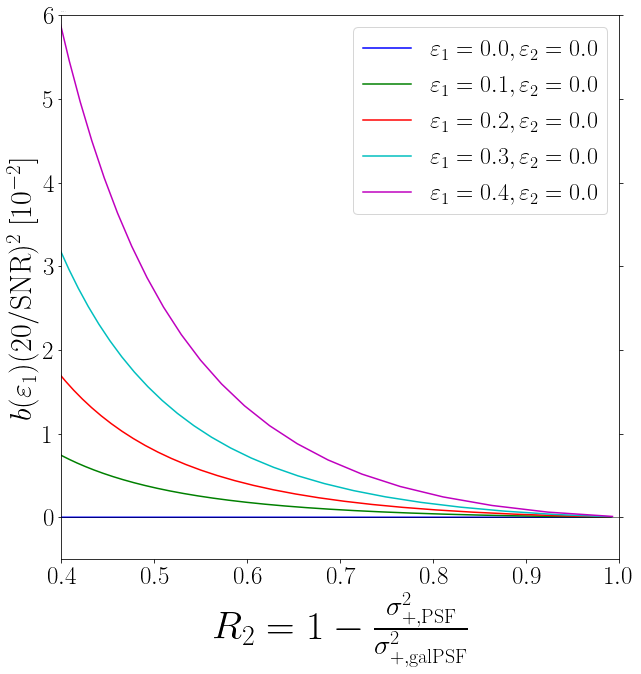

In [75]:
plot_size_vs_bias(g_parameters1, g_parameters2, image_renderer, hlrss, gs, colors, img_size,['g1_1', 'e1_1'], vary = 'g1', 
                  formatting = formatting1, plot_eps = True,  plot_chi = False )

### Second plot 

In [53]:
starts = [.275,.27,.255, .230,.2] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )

In [54]:
xlabel = '$R_{2} = 1 - \\frac{\\sigma^{2}_{\\rm{+,PSF}}}{\\sigma^{2}_{\\rm{+,galPSF}}}$'
ylabel = '$b(\\chi_{1}) (20 / \\rm{SNR})^{2} \\; [10^{-2}] $'
formatting1 = get_formatting(xlabel, ylabel,gs,  xlim = (0.4,1.0) , ylim = None, vary = 'both', 
                             check_sci = 'specific 10e1', dash_and_solid = False, hline = (0,0.5, 'black'), legend_size = 24)

['$-0.5$', '$-0.4$', '$-0.3$', '$-0.2$', '$-0.1$', '$0$', '$0.1$', '$0.2$', '$0.3$']


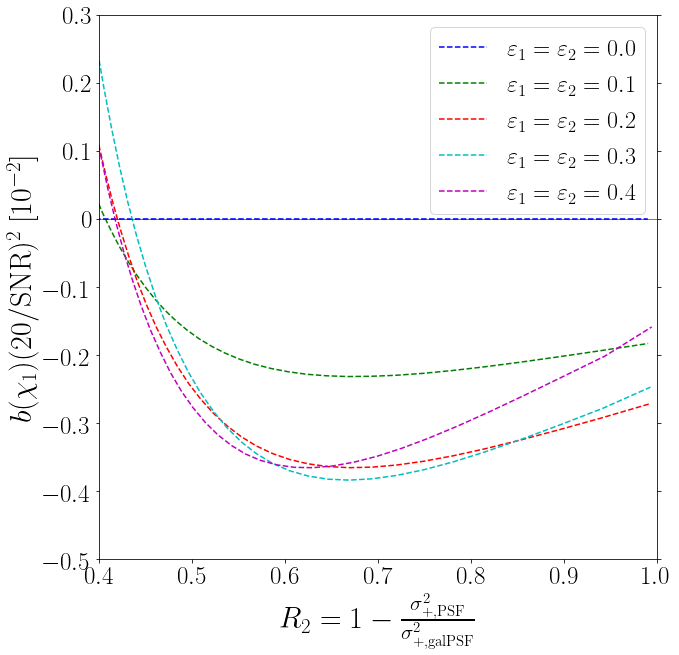

In [55]:
plot_size_vs_bias(g_parameters1, g_parameters2, image_renderer, hlrss, gs, colors, img_size, ['g1_1', 'e1_1'], 
                  formatting = formatting1, plot_eps = False,  plot_chi = True )


# Fisher results for two galaxies 

In [11]:
#parameters of first galaxy to draw. we assume that both galaxies have same psf and snr (which only depends on the background) throughout. 

model_1 = 'gaussian' #possible options of model and psf_model are in documentation. 
g1_1 = 0.2
g2_1 = 0.2
hlr_1 = .5
flux_1 = 1. 
x0_1 = 2 #this is in arcsecs.  
y0_1 = 0. 

#parameters of second galaxy to draw. 
model_2 = 'gaussian'  
g1_2 = -0.2
g2_2 = -0.2
hlr_2 = .5
flux_2 = 1. 
x0_2 = -2
y0_2 = 0.

#general parameters
snr = 20. 
psf_fwhm = .7
psf_model = 'gaussianpsf'


#project folder name where you want to write galaxy information 
project4 = data_path.joinpath('project-paper4')

#image parameters 
pixel_scale=.2 
nx = 40
ny = 40

In [12]:
cmd = (f'cd {root_path.as_posix()}; python -m smff.generate -p {project4.as_posix()} '
       f'-gal 1 --galaxy-model {model_1} --psf_model {psf_model}  --g1 {g1_1} --g2 {g2_1} --y0 {y0_1} --x0 {x0_1} '
       f'--flux {flux_1} --psf_flux 1. --hlr {hlr_1} --psf_fwhm {psf_fwhm} --snr {snr}')
subprocess.run(cmd, shell=True);

In [13]:
cmd = (f'cd {root_path.as_posix()}; python -m smff.generate -p {project4.as_posix()} '
       f'-gal 2 --galaxy-model {model_2} --psf_model {psf_model}  --g1 {g1_2} --g2 {g2_2} --y0 {y0_2} --x0 {x0_2} '
       f'--flux {flux_2} --psf_flux 1. --hlr {hlr_2} --psf_fwhm {psf_fwhm} --snr {snr}')
subprocess.run(cmd, shell=True);

## Read galaxies data, 


In [14]:
#works the same way as before, 
g_parameters = gparameters.GParameters(project4) #extract parameters from file created by generate.py 
image_renderer = images.ImageRenderer(pixel_scale=pixel_scale,
                                      nx=nx,ny=ny)
fish = fisher.Fisher(g_parameters=g_parameters,image_renderer=image_renderer, 
                     snr=snr)

In [15]:
# now displays two galaxies 
g_parameters.id_params

{'1': OrderedDict([('galaxy_model', 'gaussian'),
              ('psf_model', 'gaussianpsf'),
              ('y0', 0.0),
              ('g2', 0.2),
              ('hlr', 0.5),
              ('g1', 0.2),
              ('x0', 2.0),
              ('flux', 1.0),
              ('psf_fwhm', 0.7),
              ('psf_flux', 1.0)]),
 '2': OrderedDict([('galaxy_model', 'gaussian'),
              ('psf_model', 'gaussianpsf'),
              ('y0', 0.0),
              ('g2', -0.2),
              ('hlr', 0.5),
              ('g1', -0.2),
              ('x0', -2.0),
              ('flux', 1.0),
              ('psf_fwhm', 0.7),
              ('psf_flux', 1.0)])}

## Draw the galaxies 

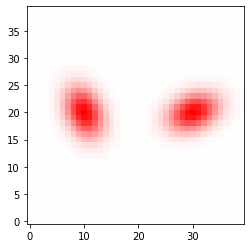

In [16]:
#get galaxy image and display it from fisher object. green is positive and red is negative 
showImage(fish.image.array)

## Produce the plot that uses the 3 different ellipticities .

In [18]:
#assume both have y = 0
def biasSeparationThree(fish,image_renderer,params,num_params):
    plt.rc('text', usetex=True)
    separation_range = (.7, 2.)  # arcsecs.
    steps = 20
    separations = np.linspace(separation_range[0],separation_range[1],steps)
  

        
#         ax.get_yaxis().get_offset_text().set_size(80)
#         #scientic notation force.
#         ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

        
    labels = ['1','2','3','4']
    #(hlr1,hl2),(g1_1,g2_1,g1_2,g2_2)
    parameters = [((.5,1.),(0.,0.,0.,0.)),
                  ((.5,1.),(0.2,0.2,0.2,0.2)),
                  ((.5,1.),(0.2,0.2,-0.2,-0.2)),
                  ((.5,.5),(0.2,0.2,-0.2,-0.2))
                 ]
    
    #plot the types of galaxies: 
    num_plots = len(parameters)
    figure = plt.figure(figsize=(FIG_SIZE, FIG_SIZE))
    for i,(label,(hlrs,ellipticities)) in enumerate(zip(labels,parameters)):
        ax = figure.add_subplot(1, num_plots, i + 1)
        
        if i == 0: 
            plt.tick_params(
            axis='both',     
            which='both',      
            bottom=True,   
            top=False,        
            left=True,
            labelleft=True,
            right=False,
            labelbottom=True)
            
        else: 
            plt.tick_params(
            axis='both',     
            which='both',      
            bottom=True,   
            top=False,        
            left=False,
            labelleft=False,
            right=False,
            labelbottom=True)

        hlr1,hlr2 = hlrs 
        g1_1,g2_1,g1_2,g2_2 = ellipticities
        
        id_params = deepcopy(fish.g_parameters.id_params)
        ids = list(id_params.keys())
        id1 = ids[0]
        id2 = ids[1]
        id_params[id1]['hlr'] = hlr1
        id_params[id2]['hlr'] = hlr2
        id_params[id1]['g1'] = g1_1
        id_params[id1]['g2'] = g2_1
        id_params[id2]['g1'] = g1_2
        id_params[id2]['g2'] = g2_2
        
        #adjust centers to maximum distance 
        id_params[id1]['x0'] = -2.
        id_params[id2]['x0'] = 2.
        id_params[id1]['y0'] = -.25
        id_params[id2]['y0'] = -.25


        
        g_parameters = gparameters.GParameters(id_params=id_params)
        fish = fisher.Fisher(g_parameters, image_renderer, snr)
        
        print('the snrs are: {}'.format(fish.snrs))
        
        ax.text(0.5, 0.8, label,
                transform=ax.transAxes,fontsize=60)
        
        ax.text(0.225, 0.225, 'a',
                transform=ax.transAxes,fontsize=60)
        
        ax.text(0.75, 0.225, 'b',
                transform=ax.transAxes,fontsize=60)
        
        #add ellipse to guide eye. 
        pixel_scale = image_renderer.pixel_scale
        
        #first get semi-major and semi-minor axis 
        #sigma1 = galsim.Gaussian(hlr1).getSigma() #assuming a gaussian galaxy with hlr what is the sigma? 
        #sigma2 = galsim.Gaussian(hlr2).getSigma() 
        g1 = np.sqrt(g1_1**2 + g2_1**2)
        g2 = np.sqrt(g1_2**2 + g2_2**2)
        q1 = (1 - g1)/( 1+ g1)
        q2 = (1 - g2)/( 1+ g2)
        b1 = np.sqrt(q1 * hlr1**2)  # assuming that hlr = np.sqrt(a * b) 
        b2 = np.sqrt(q2 * hlr2**2)
        a1 = b1/q1 
        a2 = b2/q2 
        
        
        #set the angles
        if g1 == 0: 
            theta1 = 0. 
        if g2 == 0: 
            theta2 = 0. 
        
        if g1_1 > 0 : 
            theta1 = 22.5
        if g1_2 > 0: 
            theta2 = 22.5
        else: 
            theta2 = 90 + 22.5 
                
        ell_1 = Ellipse(xy=(-10,0), width=a1*2/pixel_scale, height=b1*2/pixel_scale, angle=theta1,facecolor='none',edgecolor='b', lw=4)
        ell_2 = Ellipse(xy=(10,0), width=a2*2/pixel_scale, height=b2*2/pixel_scale, angle=theta2,facecolor='none',edgecolor='b', lw=4)

        ax.add_artist(ell_1)
        ax.add_artist(ell_2)


        
        plt.xlim((-20,20))
        plt.ylim((-20,20))
        showImage(fish.image.array,ax,vmin=None,vmax=None,extent=[-20.5,19.5,-19.5,20.5],origin='lower')
        plt.tick_params(axis='both', which='major', labelsize=55)
        plt.xticks([-15,-10, -5, 0, 5, 10, 15],['$-3$','$-2$', '$-1$', '$0$', '$1$', '$2$', '$3$'])
        plt.yticks([-20, -10, 0, 10, 20 ],['$-4$','$-2$', '$0$', '$2$', '$4$'])
        
        

    plt.tight_layout()        
        
    #now plot the ellipticity bias as a function of the distance between the two: 
    figure = plt.figure(figsize=(FIG_SIZE, FIG_SIZE))
    y_titles = ['$b(\\varepsilon^{a}_{1})$',
               '$b(\\varepsilon^{b}_{1})$',
               '$b(\\varepsilon^{a}_{2})$',
               '$b(\\varepsilon^{b}_{2})$']
    x_titles = [r'$|x^{a}_{0} - x^{b}_{0}|$ [$\rm{arcsec}$]'] * 4
    #units = ['$[10^{-1}]$','$[10^{-2}]$', '[$10^{-2}$]', '$[10^{-1}]$']
    units = ['','', '', '']
    y_final_titles = [y_title + ' {0}'.format(unit) for y_title,unit in zip(y_titles,units)]
    
    axes = []
    for i in range(num_params): 
        axes.append(figure.add_subplot(2, num_params / 2, i + 1))
        plt.axhline(0,color='purple')


    
    for i,ax in enumerate(axes): 
        plt.rc('text', usetex=True)
        param = params[i]
        ax.set_xlabel(x_titles[i], fontsize=75)
        ax.set_ylabel(y_final_titles[i], fontsize=75)
        ax.tick_params(labelsize=55)
        ax.tick_params(which='both', width=AXIS_WIDTH,length = AXIS_LENGTH)
        #plt.xticks([.7, .9, 1.1, , 10], ['$-10$', '$-5$', '$0$', '$5$', '$10$'])
    
    for i,(label,(hlrs,ellipticities)) in enumerate(zip(labels,parameters)):
        hlr1,hlr2 = hlrs 
        g1_1,g2_1,g1_2,g2_2 = ellipticities

        
        id_params = deepcopy(fish.g_parameters.id_params)
        ids = list(id_params.keys())
        id1 = ids[0]
        id2 = ids[1]
        id_params[id1]['hlr'] = hlr1
        id_params[id2]['hlr'] = hlr2
        id_params[id1]['g1'] = g1_1
        id_params[id1]['g2'] = g2_1
        id_params[id2]['g1'] = g1_2
        id_params[id2]['g2'] = g2_2
        biases = {}
        for separation in separations:
            pos1 = -separation / 2
            pos2 = separation / 2
            id_params[id1]['x0'] = pos1
            id_params[id2]['x0'] = pos2
            g_parameters = gparameters.GParameters(id_params=id_params)
            fish = fisher.Fisher(g_parameters, image_renderer, snr)
            for i in range(num_params):
                param = params[i]
                if param not in biases:
                    biases[param] = []
                bias = fish.biases[param]
                biases[param].append(bias)

        for i,ax in enumerate(axes):
            param = params[i]
            ax.plot(separations, biases[param],'-o',linewidth=3,markersize=12,label=label)
            #ax.get_yaxis().get_offset_text().set_size(80)
            #scientic notation force.
            #ax.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
            legend = ax.legend(loc='best', fontsize=40)

    figure.subplots_adjust(wspace=.5)
    plt.tight_layout()                      

the snrs are: [20.0, 11.560815845594425]
the snrs are: [20.0, 11.639984000919519]
the snrs are: [20.0, 11.685131375754938]
the snrs are: [20.0, 20.000006097875662]


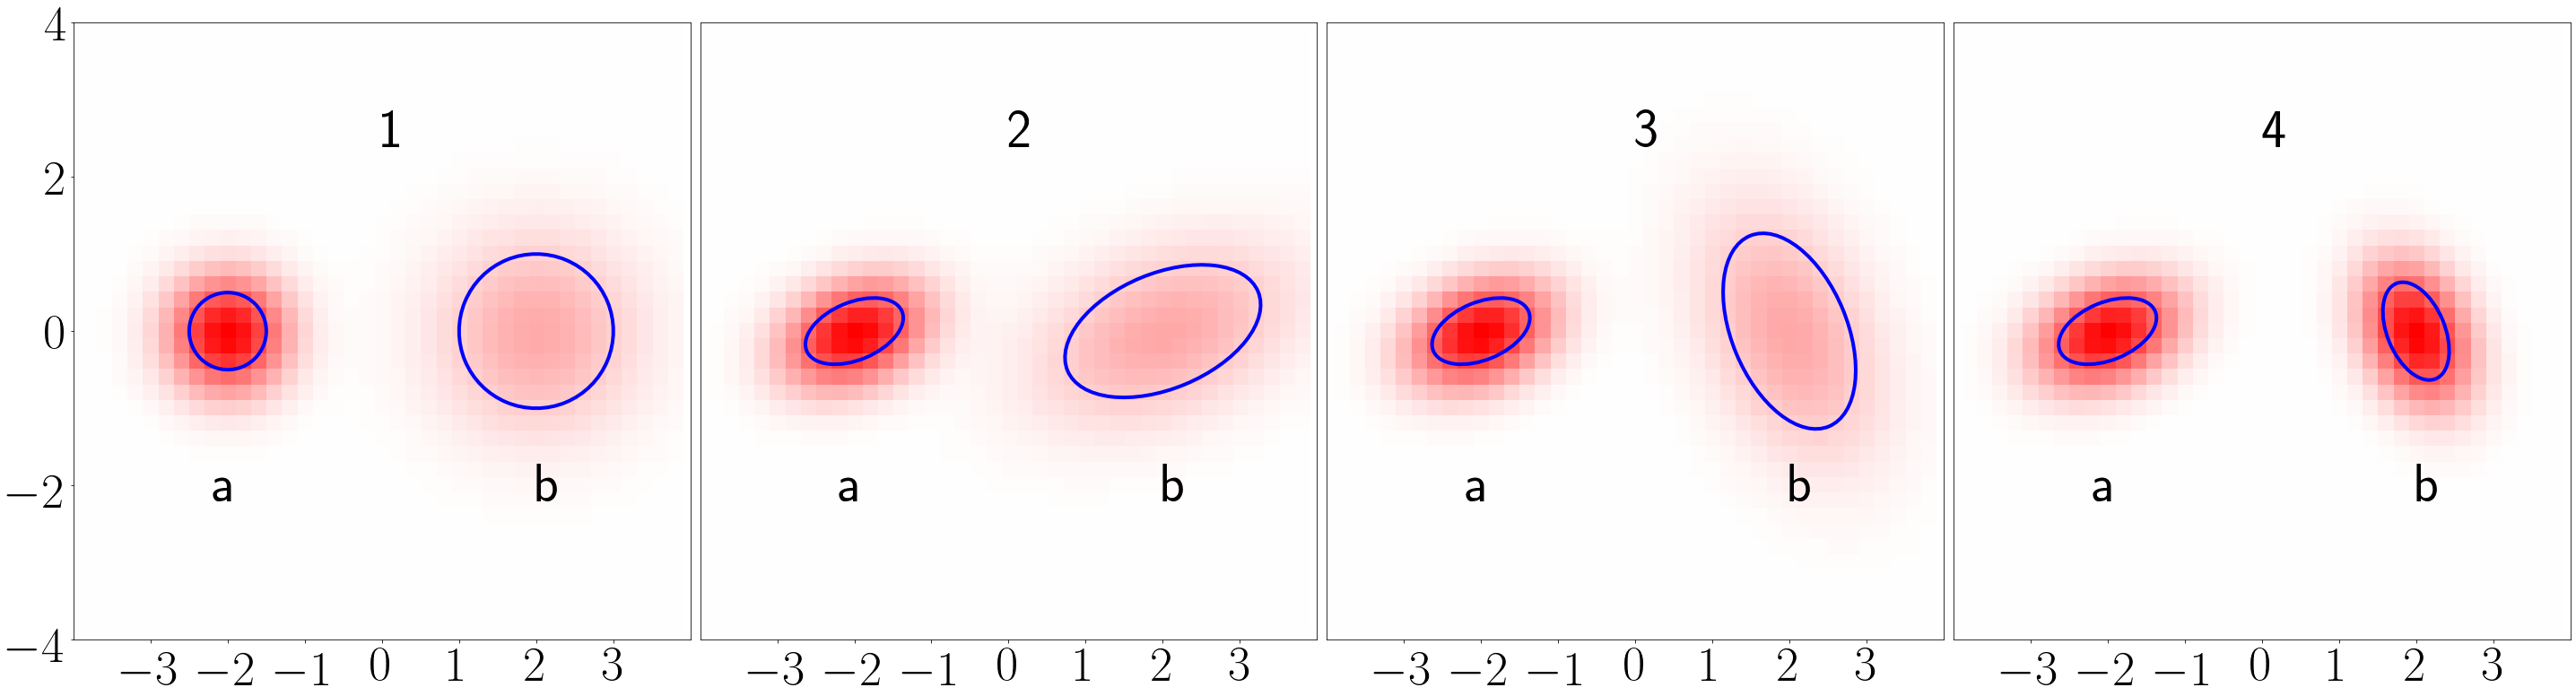

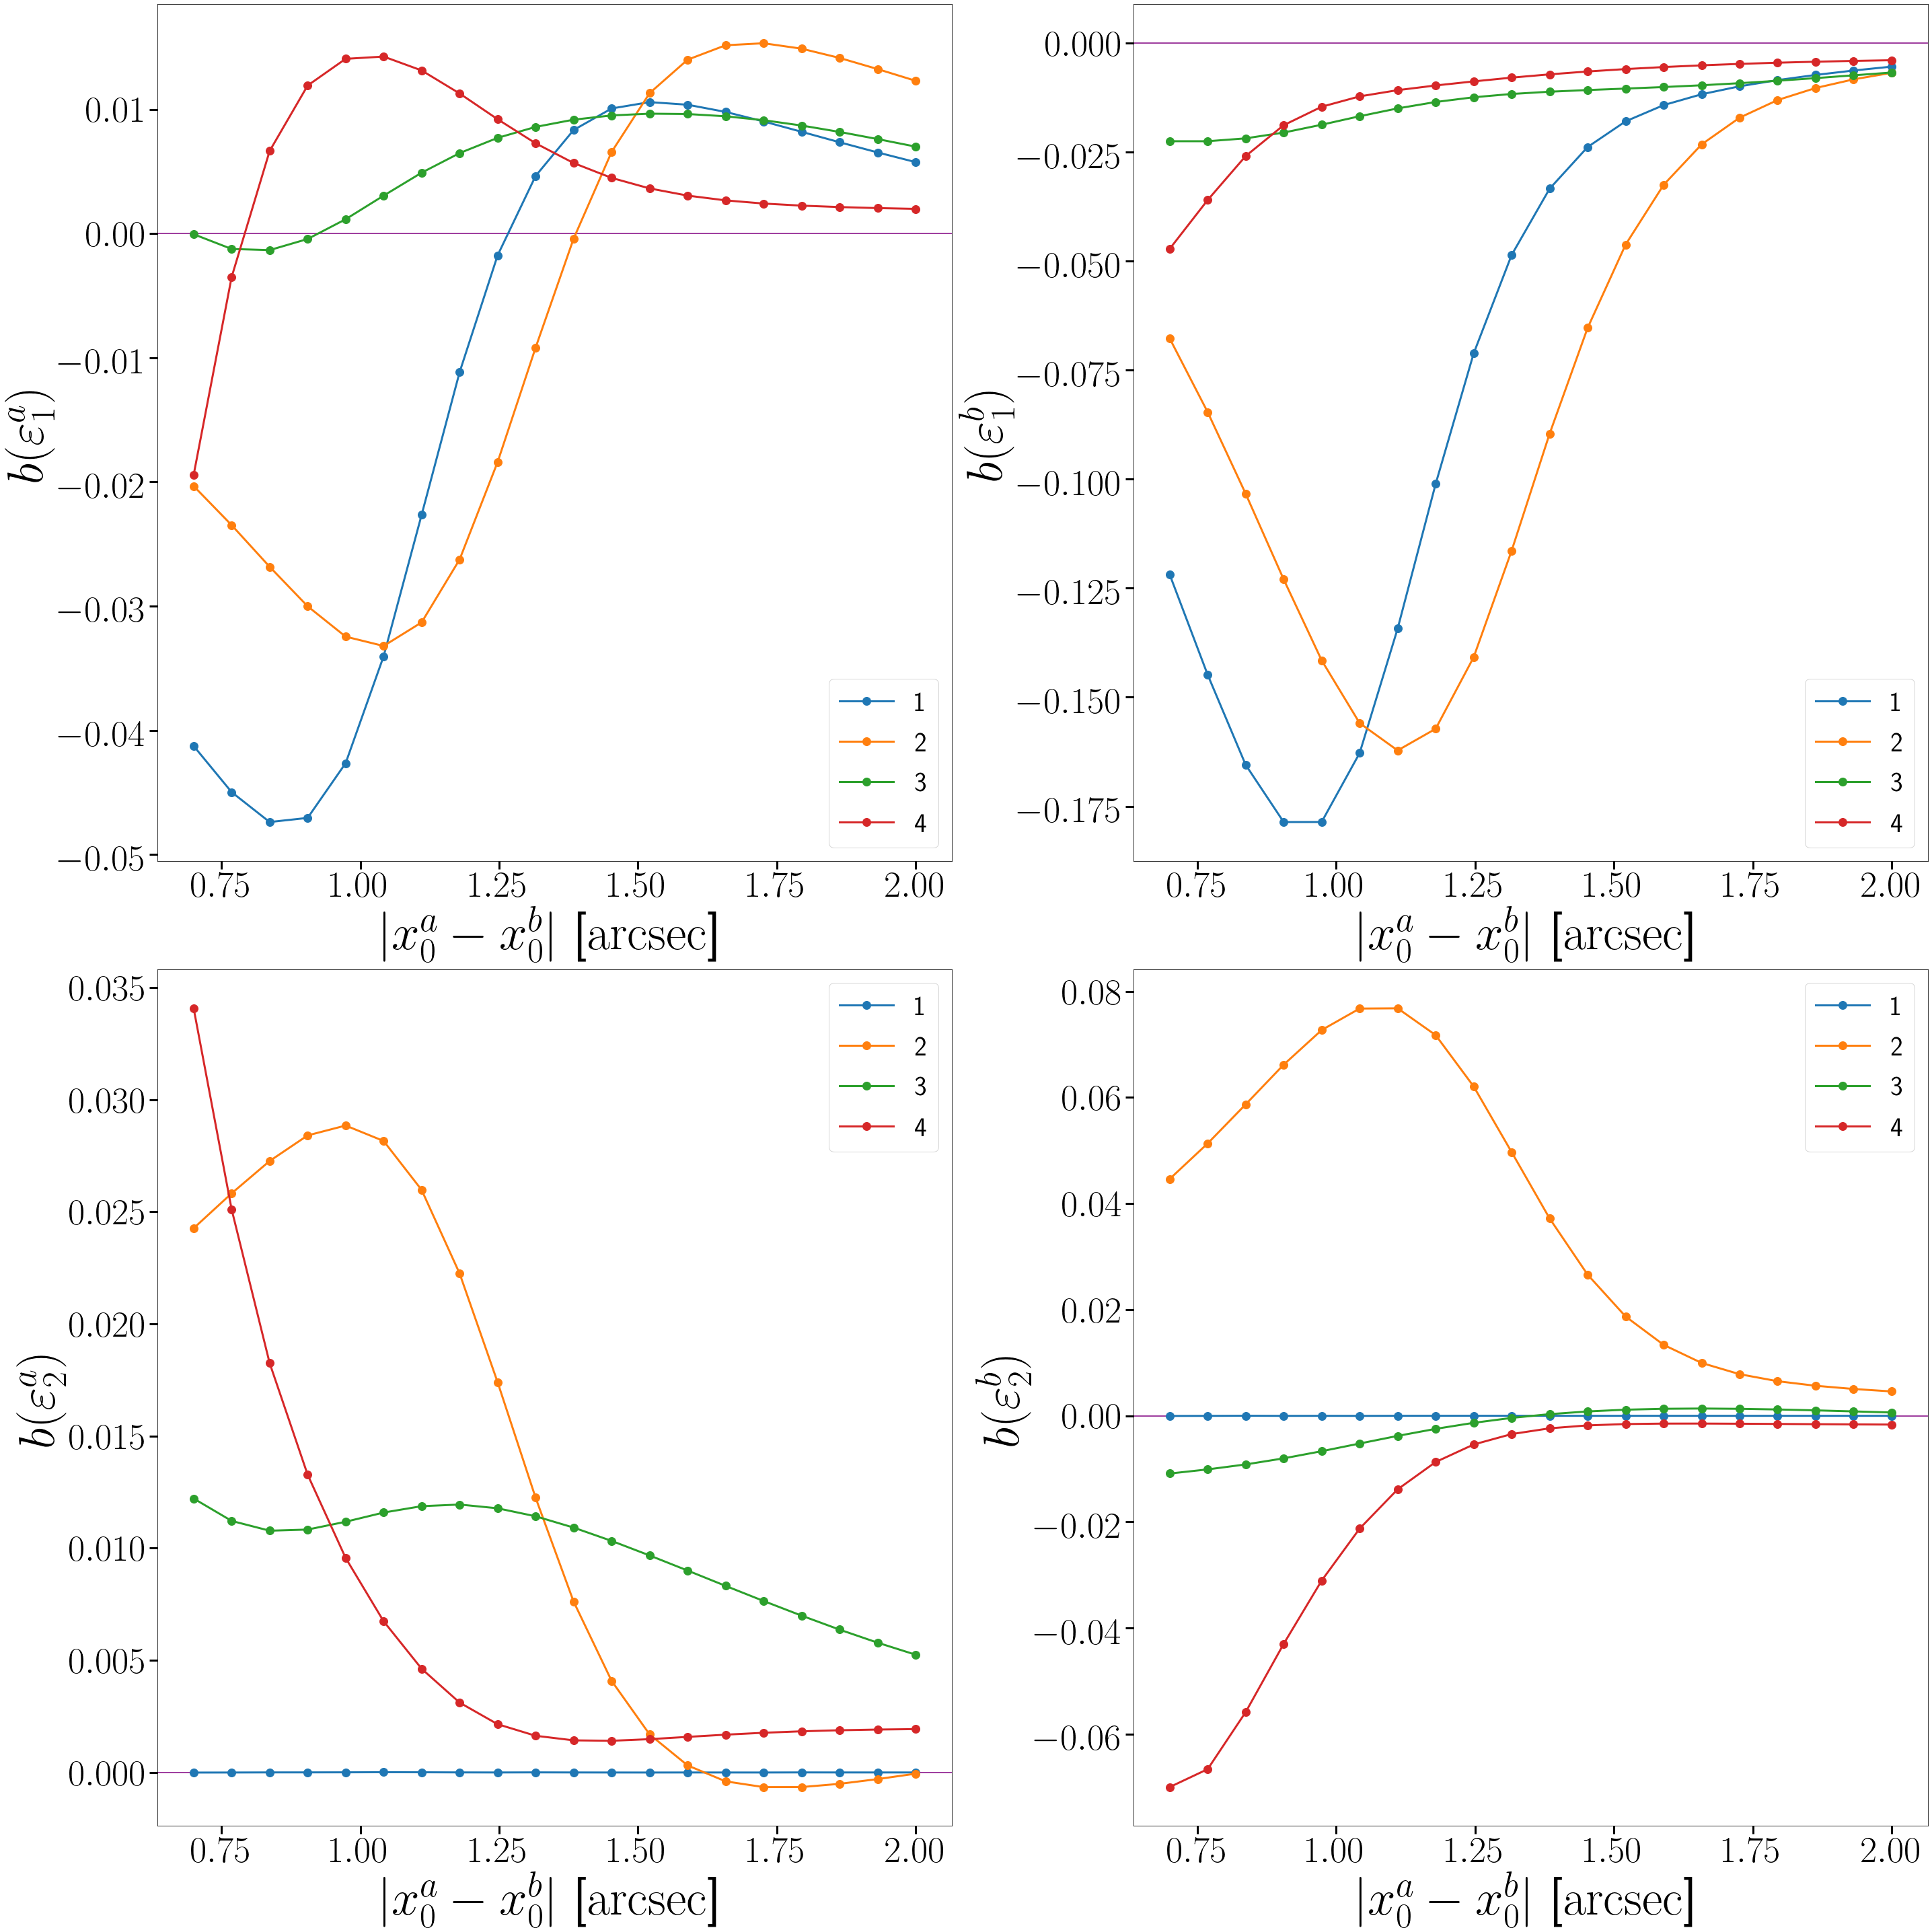

In [19]:
biasSeparationThree(fish,image_renderer,['g1_1','g1_2','g2_1','g2_2'],4)

# Triange plot and fits using lmfit 

In [125]:
from smff.analysis import readfits

In [126]:
#project folder name where you want to write galaxy information 
project_eps = data_path.joinpath('project-fit-eps')
project_chi = data_path.joinpath('project-fit-chi') 

In [127]:
#parameters of galaxy to draw. 
model = 'gaussian' #possible options of model and psf_model are in documentation. 
psf_model = 'gaussianpsf'
g1 = .2
g2 = .2 
hlr = 0.7 
psf_fwhm = .7
snr = 20.
x0 = 1. # arcsecs
y0 = 1.

#image parameters 
pixel_scale=.2 
nx = 45
ny = 45
assert nx == ny, "Assumed to be equal for this part"

In [128]:
#with \varepsilon 
# running this will delete the data so be careful! If you are really sure you want to do that, 
# then uncomment the last line. 

cmd = (f'cd {root_path.as_posix()}; python -m smff.generate -p {project_eps.as_posix()} -gal 1 --galaxy-model {model} --psf_model {psf_model} ' 
       f'--g1 {g1} --g2 {g2} --x0 {x0} --y0 {y0}  '
       f'--flux 1. --psf_flux 1. --hlr {hlr} --psf_fwhm {psf_fwhm} --snr {snr}')
print(cmd)
# subprocess.run(cmd, shell=True);

cd /nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/SMFF; python -m smff.generate -p /nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/SMFF/data/project-fit-eps -gal 1 --galaxy-model gaussian --psf_model gaussianpsf --g1 0.2 --g2 0.2 --x0 1.0 --y0 1.0  --flux 1. --psf_flux 1. --hlr 0.7 --psf_fwhm 0.7 --snr 20.0


In [129]:
#with \chi 
shr = galsim.shear.Shear(g1 = g1, g2 = g2) 
e1, e2 = shr.e1, shr.e2 #obtain chi to match g1,g2 
cmd = (f'cd {root_path.as_posix()}; python -m smff.generate -p {project_chi.as_posix()} -gal 1 --galaxy-model {model} --psf_model {psf_model} ' 
       f'--e1 {e1} --e2 {e2} --x0 {x0} --y0 {y0}  '
       f'--flux 1. --psf_flux 1. --hlr {hlr} --psf_fwhm {psf_fwhm} --snr {snr}')
print(cmd)
# subprocess.run(cmd, shell=True);

cd /nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/SMFF; python -m smff.generate -p /nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/SMFF/data/project-fit-chi -gal 1 --galaxy-model gaussian --psf_model gaussianpsf --e1 0.37037037037037035 --e2 0.37037037037037035 --x0 1.0 --y0 1.0  --flux 1. --psf_flux 1. --hlr 0.7 --psf_fwhm 0.7 --snr 20.0


## Get galaxy from file

In [130]:
g_parameters = gparameters.GParameters(project_eps) #extract parameters from file created by generate.py 
image_renderer = images.ImageRenderer(pixel_scale=pixel_scale,nx=nx,ny=ny)
fish = fisher.Fisher(g_parameters=g_parameters,image_renderer=image_renderer, snr=snr)

# make sure parameters look good
fish.g_parameters.id_params

{'1': OrderedDict([('galaxy_model', 'gaussian'),
              ('psf_model', 'gaussianpsf'),
              ('flux', 1.0),
              ('x0', 1.0),
              ('g2', 0.2),
              ('y0', 1.0),
              ('hlr', 0.7),
              ('g1', 0.2),
              ('psf_fwhm', 0.7),
              ('psf_flux', 1.0)])}

In [131]:
# display default parameters for the fits. 
mins = defaults.get_minimums(g_parameters, fish.image)
maxs = defaults.get_maximums(g_parameters, fish.image)
init_values = defaults.get_initial_values_fit(g_parameters)
print(mins)
print(maxs)
print(init_values)

{'flux_1': 0.0, 'x0_1': -4.5, 'g2_1': -0.7, 'y0_1': -4.5, 'hlr_1': 0.0, 'g1_1': -0.7}
{'flux_1': inf, 'x0_1': 4.5, 'g2_1': 0.7, 'y0_1': 4.5, 'hlr_1': inf, 'g1_1': 0.7}
{'flux_1': 1.113225560171127, 'x0_1': 1.1872154657085996, 'g2_1': 0.2943460835672177, 'y0_1': 1.011704156713411, 'hlr_1': 0.7532492461703509, 'g1_1': 0.3230082710445332}


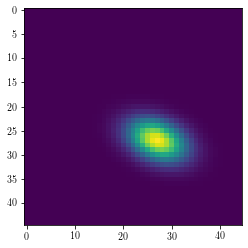

In [132]:
# example noisy image of the galaxy we are fitting
plt.imshow(fish.image.array)

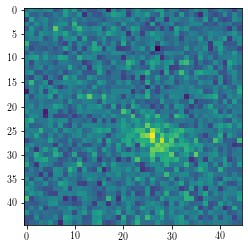

In [133]:
# example noisy image of the galaxy we are fitting
plt.imshow(images.add_noise(fish.image, 20, 0)[0].array)

As you can see by eye it's already hard to make out this galaxy. 

## Perform fits

In [134]:
#using lm does a fitting to number_fits noise realizations of the galaxy above 
#produces a file for each of the fittings in the given project folder. 
number_fits = 10000

# you will probably want to run this command in a cluster, I use the SLAC cluster so the code 
# below will only work for that with the option -rfs will only work in SLAC, you will need to adapt the local 
# way of running to your cluster. 

In [135]:
print("IMPORTANT: Run these commands outside the smff folder.")
print("IMPORTANT: Depending on the number of fits, the local command will take a really long time.\n ")

# this is the cmd for local (but will take a long time)
cmd_local = f'python -m smff.fitting -p {project_eps} --snr {snr} -n {number_fits} --slen {nx} -rf'

#and for a SLAC computer. 
cmd_slac = f'python -m smff.fitting -p {project_eps} --snr {snr} -n {number_fits} -rfs short --slen {nx}'


print(cmd_local)
print(cmd_slac)
print()
print("IMPORTANT: To rerun in the same folder without overwritting previous results remove the SNR.\n")

cmd_local = f'python -m smff.fitting -p {project_eps} -n {number_fits} -rf --slen {nx}'

#and for a SLAC computer. 
cmd_slac = f'python -m smff.fitting -p {project_eps} -n {number_fits} -rfs short --slen {nx}'

print(cmd_local)
print(cmd_slac)

IMPORTANT: Run these commands outside the smff folder.
IMPORTANT: Depending on the number of fits, the local command will take a really long time.
 
python -m smff.fitting -p /nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/SMFF/data/project-fit-eps --snr 20.0 -n 10000 --slen 45 -rf
python -m smff.fitting -p /nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/SMFF/data/project-fit-eps --snr 20.0 -n 10000 -rfs short --slen 45

IMPORTANT: To rerun in the same folder without overwritting previous results remove the SNR.

python -m smff.fitting -p /nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/SMFF/data/project-fit-eps -n 10000 -rf --slen 45
python -m smff.fitting -p /nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/SMFF/data/project-fit-eps -n 10000 -rfs short --slen 45


In [ ]:
# alternatively, you can download the 40,000 fits for project-fit-eps using the link below: 

https://github.com/ismael2395/ShapeMeasurementFisherFormalism/blob/master/data/40000-fits.zip

## Process the results from files, 


In [136]:
g_parameters = gparameters.GParameters(project_eps)
image_renderer = images.ImageRenderer(pixel_scale=pixel_scale,nx=nx,ny=ny)
fish = fisher.Fisher(g_parameters=g_parameters,image_renderer=image_renderer, snr=snr)

In [137]:
print(f'Fits from "{project_eps.name}" are being extracted')
pulls,residuals,biases,pull_means,res_stds,pull_mins,pull_maxs,redchis = readfits.read_results(project_eps,
                                                                                               g_parameters,fish)

Fits from "project-fit-eps" are being extracted


In [138]:
print(f"check number of fits is correct: {len(residuals['flux_1'])}")

check number of fits is correct: 40000


## Plot some residuals to see if they make sense.

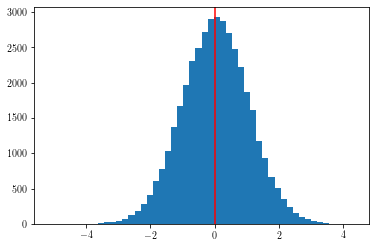

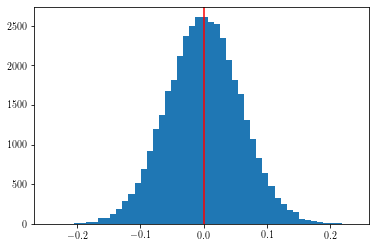

In [139]:
#all should be centered around 0. 
plt.figure()
plt.hist(np.array(pulls['g1_1']), bins=50)
plt.axvline(0.0, c='r')

plt.figure()
plt.hist(np.array(residuals['x0_1']), bins=50)
plt.axvline(0.0, c='r')

In [140]:
# the two bins next to the central one are due to pixelization effects. 

### Produce the figure containing fisher 68% prediction, 

In [168]:
import corner 

In [169]:
#constants needed for the plots below 
number_fits = 40000
EXTENT_PULL = (-3, 3)
BINS_PULL = 40
SIG_DIGITS = 4

In [170]:
def errorEllipseCor(centroid, cor_xy, alpha=1.52):
    """
    Return a correlation ellipse according to Dan Coe paper arxiv.0906.4123.

    We use correlations instead of covariances for the ellipses because most of
    the parameters in our models have dimensions.
    Confidence level by default is 68.3% -> alpha = 1.52 according to the same
    paper.

    Args:
        centroid(:py:tuple): Position of the center of the ellipse in
                             (x,y) form.

    Returns:
        An mpatch.Ellipse object
    """
    import matplotlib.patches as mpatch

    a = 1 + cor_xy
    b = 1 - cor_xy
    theta = 45
    width = 2 * alpha * a
    height = 2 * alpha * b

    ellipse = mpatch.Ellipse(xy=centroid, width=width, height=height,
                             angle=theta, edgecolor='r', fc='None', lw=2)

    return ellipse

In [171]:
def fisher_prediction(params,bound_mins,bound_maxs,fish,number_fits):
    """Draws a triangle shaped plot with the fisher prediction for 68% confidence level"""
    from scipy.stats import norm
    
    fish_figure = plt.figure(figsize=(11, 11)) #this is the figure containing the fisher predictions. 
    normalized_area = (EXTENT_PULL[1] - EXTENT_PULL[0]) * (number_fits / BINS_PULL)
    param_names = fish.param_names
    num_params = len(params)
    color_hist = 'red'
    for param in params:
        # produce pull plot.

        dim = num_params + 1  # for redchi add extra dimension.
        
        #here we create our triangle. 
        ####i are the rows, or the y-axis, and j are the columns or the x-axis. 
        for i in range(dim):
            for j in range(dim):
                plt.rc('text', usetex=True)
                if i < num_params and j < num_params and i >= j:
                    ax = fish_figure.add_subplot(dim, dim, dim * i + j + 1)
                    
                    param_i = param_names[i]
                    param_j = param_names[j]
                    sigma_i = np.sqrt(fish.covariance_matrix[param_i,param_i])
                    sigma_j = np.sqrt(fish.covariance_matrix[param_j, param_j])
                    mean = (fish.biases[param_j] / sigma_j,fish.biases[param_i] / sigma_i)
                    cor_xy = fish.correlation_matrix[param_j, param_i]

                    if i == j:
                        sigma_gauss = 1 #normalize normal pdf.
                        x = np.linspace(EXTENT_PULL[0], EXTENT_PULL[1], 1000)
                        ax.plot(x, normalized_area * norm.pdf(x, mean[0],sigma_gauss),color=color_hist)
                        sigma_fisher = round(sigma_i, SIG_DIGITS)
                        sigma_fits = round(res_stds[param_i], SIG_DIGITS)

                        #error of bias_fits
                        sigma_1 = round(sigma_fits / np.sqrt(number_fits),SIG_DIGITS)
                        #error of sigma_fits
                        sigma_2 = round(sigma_fits / np.sqrt(2*number_fits), SIG_DIGITS)
                        bias_fisher = round(fish.biases[param_i],SIG_DIGITS)
                        bias_fits = round(biases[param_i],SIG_DIGITS)
                        
                        if i == 4 or i==5: 
                            data = (
                                  r'\begin{eqnarray*}' +
                                  r'\sigma_{\rm F}' + '&=&' +
                                  '{:.4f}'.format(sigma_fisher) +
                                  r'\\' +
                                  r'\sigma_{\rm fit}' + '&=&' +
                                  '{:.4f}'.format(sigma_fits) +
                                  r'\pm' +
                                  '{:.4f}'.format(sigma_2) +
                                  r'\\' +
                                  r'b_{F}' + '&=&' +
                                  '{:+.4f}'.format(bias_fisher) +
                                  r'\\' +
                                  r'b_{\rm fit}' + '&=&' +
                                  '{:+.4f}'.format(bias_fits) +
                                  r'\pm' +
                                  '{:.4f}'.format(sigma_1) +
                                  r'\end{eqnarray*}')

                        elif i == 1 or i==2:
                            #avoid + or - in the 0s
                            data = (
                                  r'\begin{eqnarray*}' +
                                  r'\sigma_{\rm F}' + '&=&' +
                                  '{:.4f}'.format(sigma_fisher) +
                                  r'\\' +
                                  r'\sigma_{\rm fit}' + '&=&' +
                                  '{:.4f}'.format(sigma_fits) +
                                  r'\pm' +
                                  '{:.4f}'.format(sigma_2) +
                                  r'\\' +
                                  r'b_{F}' + '&=&' +
                                  '{:.4f}'.format(0) +
                                  r'\\' +
                                  r'b_{\rm fit}' + '&=&' +
                                  '{:+.4f}'.format(bias_fits) +
                                  r'\pm' +
                                  '{:.4f}'.format(sigma_1) +
                                  r'\end{eqnarray*}')
                        
                        else: 
                            data = (
                                  r'\begin{eqnarray*}' +
                                  r'\sigma_{\rm F}' + '&=&' +
                                  '{:.4f}'.format(sigma_fisher) +
                                  r'\\' +
                                  r'\sigma_{\rm fit}' + '&=&' +
                                  '{:.4f}'.format(sigma_fits) +
                                  r'\pm' +
                                  '{:.4f}'.format(sigma_2) +
                                  r'\\' +
                                  r'b_{F}' + '&=&' +
                                  '{:+.4f}'.format(bias_fisher) +
                                  r'\\' +
                                  r'b_{\rm fit}' + '&=&' +
                                  '{:+.4f}'.format(bias_fits) +
                                  r'\pm' +
                                  '{:.4f}'.format(sigma_1) +
                                  r'\end{eqnarray*}')




                        ax.text(1.725, .35, data,
                                transform=ax.transAxes, ha='center',
                                fontsize=10,
                                fontweight='bold')

                        # add green lines indicating bounds.
                        ax.axvline(x=pull_mins[param_j], color='g')
                        ax.axvline(x=pull_maxs[param_j], color='g')

                    elif i > j:
                        # draw an error_ellipse in off-diagonals axises.
                        ellip = errorEllipseCor(mean, cor_xy)
                        ax.add_patch(ellip)

                        ax.axhline(y=pull_mins[param_i], color='g')
                        ax.axhline(y=pull_maxs[param_i], color='g')


                        ax.axvline(x=pull_mins[param_j], color='g')
                        ax.axvline(x=pull_maxs[param_j], color='g')

                else:
                    # add the chi row. 
                    ax = fish_figure.add_subplot(dim,
                                                 dim,
                                                 dim * i + j + 1)
            
                ax.tick_params(axis='both', which='major', labelsize=14, pad=-2)

                
    plt.rc('text', usetex=True)
    return fish_figure

/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/miniconda3/envs/igalsim/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/miniconda3/envs/igalsim/lib/python3.7/site-packages/ipykernel_launcher.py:133: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


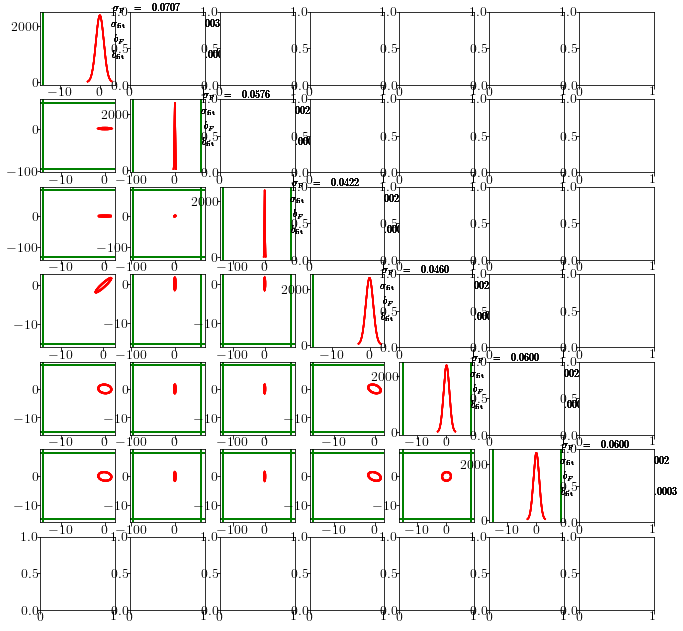

In [172]:
fish_figure = fisher_prediction(pulls.keys(),pull_mins,pull_maxs,fish,number_fits)

### Produce final corner plot 

In [173]:
def fit_plots(project, pulls,pull_mins,pull_maxs,pull_means,redchis,fish,fish_figure=None, img_suffix='png'):
    """Draws a triangle plot with fisher predictions overalayed and the results from the fittings."""
    param_names = fish.param_names
    num_params = fish.num_params

    # have to transform point.values to a convenient form for the plot.
    extents = [EXTENT_PULL] * num_params + [(min(redchis),max(redchis))]
    points_plot = []
    truths = []
    plot_names = []

    for param in param_names:
        if 'g1' in param:
            tex_param = '$\\varepsilon_{1}$'
        elif 'g2' in param:
            tex_param = '$\\varepsilon_{2}$'
        elif 'x0' in param:
            tex_param = r'$x_{0}$'
        elif 'y0' in param:
            tex_param = r'$y_{0}$'
        elif 'hlr' in param: 
            tex_param = r'$\rm{HLR}$'
        else:
            tex_param = r'$\rm{flux}$'
        plot_names.append(tex_param)

    plot_names.append(r'$\chi^{2}/dof$')

    for param in param_names:
        points_plot.append(pulls[param])
        truths.append(pull_means[param])

    #chi2, redchi should be centered around 1
    truths.append(1)
    points_plot.append(redchis)
    
    hist2d_kwargs = {'plot_datapoints':True,'plot_density':False,'plot_contours':False, 
                     'no_fill_contours':False,'fill_contours':False, 'data_kwargs': {'alpha':0.1, 'markevery':4}  }
    #here we overlay the produced fish_figure and the triangle plot. 
    figure1 = corner.corner(np.array(points_plot).transpose(),
                              bins=BINS_PULL,
                              labels=plot_names,
                              range=extents,
                              truths=truths,
                              show_titles=True,
                              title_fmt=None, 
                              title_kwargs={"fontsize": 22},label_kwargs={"fontsize": 18, "labelpad":20},
                              fig=fish_figure,hist_kwargs=None,**hist2d_kwargs)

    figure1.subplots_adjust(hspace=.2, wspace=.2) #adjust to avoid overlap.
    figure_path = project.joinpath(f'triangle.{img_suffix}')
    print(figure_path.as_posix())
    plt.rc('text', usetex=True)
    figure1.savefig(figure_path) 

In [174]:
#figure is saved in project folder because of its complexity. 
fit_plots(project_eps,pulls,pull_mins,pull_maxs,pull_means,redchis,fish,fish_figure)

/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/SMFF/data/project-fit-eps/triangle.png


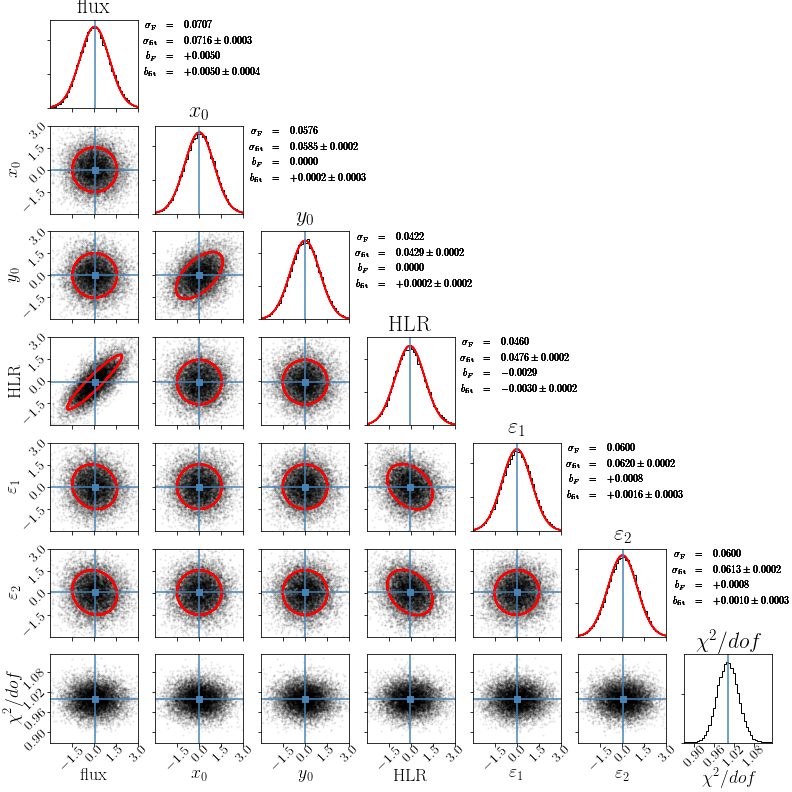

In [175]:
from IPython.display import Image
PATH = "/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/SMFF/data/project-fit-eps/triangle.png"
Image(PATH, width=700, height=700)